In [1]:
#Installation des lib pour le profiling, la data manipulation, la visualisation, création de modèles (scikit-learn/keras pour modèles), widgets interactifs (ipywidgets), et interprétation (shap pour explain/ability).

"""%pip install ydata-profiling
%pip install pandas matplotlib seaborn scikit-learn keras ipywidgets
%pip install shap
"""

'%pip install ydata-profiling\n%pip install pandas matplotlib seaborn scikit-learn keras ipywidgets\n%pip install shap\n'

In [2]:


%matplotlib inline 
# Permet l'activation l'affichage en ligne des graphiques matplotlib dans Jupyter

# 1- Exploration et préparation des données

In [3]:

# IMPORTATION DES LIBRAIRIES PRINCIPALES
# Pandas & NumPy pour la Manipulation et calcul sur les données
# TensorFlow/Keras pourConstruction de modèles de deep learning
# Sklearn pour création de Modèles classiques et métriques
# Matplotlib/Seaborn pour la Visualisation des données

import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
# Lecture du fichier CSV contenant les données de maintenance prédictive

df = pd.read_csv("ai4i2020.csv")

c:\Users\Falleiz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [4]:

# AFFICHAGE DES 5 PREMIÈRES LIGNES DU DATASET

df.head()

UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    0    0    0  
1    0    0    0    0  
2    0    0    0    0  
3    0    0    0    0  
4    0    0    0    0

In [5]:

# CONFIGURATION DE L'AFFICHAGE PANDAS, pour une mailleure visibilité des données du dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)


In [6]:

# Nous voulons ici générer un rapport Ydata Profiling complet qui inclut :
# - Statistiques descriptives par colonne
# - Détection des valeurs manquantes et des doublons
# - Analyse des corrélations entre variables
# - Identification des variables corrélées fortement
# Sauvegarde le rapport en HTML pour consultation

from ydata_profiling import ProfileReport 
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_notebook_iframe()
profile.to_file("output.html")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 14/14 [00:00<00:00, 28.71it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# 2- Modélisation avec Autoencodeurs

## Feature engineering

In [7]:

# Dans cette étape, nous voulons créer des features spécifiques au domaine qui améliorent 
# la capacité du modèle à détecter les anomalies sans pour autant augmenter la complexité ou perdre en information.

# FEATURES PHYSIQUES 
# power_kw : Calcule la Puissance mécanique (en kW) = (Couple * Vitesse) / 9550
df['power_kw'] = (df['Torque [Nm]'] * df['Rotational speed [rpm]']) / 9550

# temp_diff : Calcule la différence de température = Température du processus - Température de l'air
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']

# speed_torque_ratio : Calcule le Rapport vitesse/couple (indique l'efficacité mécanique)
df['speed_torque_ratio'] = df['Rotational speed [rpm]'] / (df['Torque [Nm]'] + 1)

# FEATURES D'USURE 
# wear_level : Peermet une Catégorisation discrète de l'usure de l'outil 
max_wear = df['Tool wear [min]'].max()
df['wear_level'] = pd.cut(df['Tool wear [min]'], 
                          bins=[0, 80, 160, max_wear + 1],
                          labels=[0, 1, 2],
                          include_lowest=True)
df['wear_level'] = pd.to_numeric(df['wear_level'], errors='coerce').fillna(0).astype(int)

# high_wear : Indicateur binaire d'usure extrême (> 200 min)
df['high_wear'] = (df['Tool wear [min]'] > 200).astype(int)

#FEATURES D'INTERACTION (EFFEt COMBINÉ) 
# thermal_load : Charge thermique = Différence de température × Puissance
df['thermal_load'] = df['temp_diff'] * df['power_kw']

# mechanical_stress : Stress mécanique augmentant avec l'usure
df['mechanical_stress'] = df['Torque [Nm]'] * (1 + df['Tool wear [min]'] / 250)

# ENCODAGE ONE-HOT DES VARIABLES CATÉGORIelles 
# Nous voulons transformer la colonne 'Type' en variables binaires (Type_H, Type_L, Type_M)
df_encoded = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=False)

print(f"\n Feature engineering terminé")
print(f"   Nouvelles features créées : 9")
print(f"   Dataset final : {df_encoded.shape}")



 Feature engineering terminé
   Nouvelles features créées : 9
   Dataset final : (10000, 23)


In [8]:

# DÉFINITION DE LA LISTE DES FEATURES POUR L'AUTOENCODER
# Nous voulons dans cette partie sélectionne toutes les features pertinentes qui seront utilisées pour l'entraînement des modèles d'anomalie
# Cette liste inclut :
# - Variables physiques (température, vitesse, couple)
# - Features engineered (puissance, charge thermique, stress)
# - Variables catégorielles encodées (Type)
#Notre choix s'est porté cette liste

features_for_autoencoder = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'power_kw',
    'temp_diff',
    'speed_torque_ratio',
    'wear_level',
    'high_wear',
    'thermal_load',
    'mechanical_stress',
    'Type_H',
    'Type_L',
    'Type_M'
]

print(f"\n Features sélectionnées : {len(features_for_autoencoder)}")


 Features sélectionnées : 15


**ANALYSE DES FEATURES - DISCRIMINATION NORMAUX vs ANOMALIES**

In [9]:

# SÉPARATION DES DONNÉES : NORMAUX vs ANOMALIES
# Nous voulons diviser le dataset en deux groupes pour l'analyse comparative :
# - df_normal : Machine failure = 0
# - df_anomaly : Machine failure = 1
# Cela favorise la comparaison des distributions et des statistiques

df_normal = df_encoded[df_encoded['Machine failure'] == 0]
df_anomaly = df_encoded[df_encoded['Machine failure'] == 1]

print(f"\nNombre de normaux : {len(df_normal)}")
print(f"Nombre d'anomalies : {len(df_anomaly)}")


Nombre de normaux : 9661
Nombre d'anomalies : 339


**STATISTIQUES COMPARATIVES**

In [10]:
# ANALYSE STATISTIQUE 
# on calcule pour chaque feature :
# 1. Moyennes pour normaux et anomalies
# 2. Pourcentage de différence relative
# 3. Cohen's d : Taille de l'effet statistique 
#    - d > 0.5 : effet moyen (feature pertinente)
#    - d > 0.8 : effet large (feature très pertinente)
# 4. p-value du t-test : Significativité statistique
# 
# Objectif : Identifier les 6 meilleures features pour la suite de l'analyse

from scipy import stats
import numpy as np
import pandas as pd
print("\n" + "="*60)
print("ÉTAPE 1 : COMPARAISON DES MOYENNES")
print("="*60)

features_to_analyze = features_for_autoencoder

results = []

for feature in features_to_analyze:
    mean_normal = df_normal[feature].mean()
    mean_anomaly = df_anomaly[feature].mean()
    std_normal = df_normal[feature].std()
    std_anomaly = df_anomaly[feature].std()
    
    # Différence en %
    if mean_normal != 0:
        diff_pct = ((mean_anomaly - mean_normal) / abs(mean_normal)) * 100
    else:
        diff_pct = 0
    
    # Test statistique: t-test
    t_stat, p_value = stats.ttest_ind(df_normal[feature], df_anomaly[feature])
    
    # Cohen's d 
    pooled_std = np.sqrt((std_normal**2 + std_anomaly**2) / 2)
    cohens_d = (mean_anomaly - mean_normal) / pooled_std if pooled_std != 0 else 0
    
    results.append({
        'feature': feature,
        'mean_normal': mean_normal,
        'mean_anomaly': mean_anomaly,
        'diff_pct': diff_pct,
        'cohens_d': abs(cohens_d),
        'p_value': p_value,
        'significant': p_value < 0.05
    })

# Créer DataFrame
df_results = pd.DataFrame(results)

# Trier par Cohen's d (effet le plus fort)
df_results = df_results.sort_values('cohens_d', ascending=False)

print("\n FEATURES TRIÉES PAR POUVOIR DISCRIMINANT (Cohen's d) :")
print("-"*100)
print(f"{'Feature':<30} {'Normal':>10} {'Anomalie':>10} {'Diff %':>8} {'Cohen d':>8} {'p-value':>10} {'Signif':>7}")
print("-"*100)

for _, row in df_results.iterrows():
    signif = " OUI" if row['significant'] else " NON"
    print(f"{row['feature']:<30} {row['mean_normal']:>10.3f} {row['mean_anomaly']:>10.3f} "
          f"{row['diff_pct']:>7.1f}% {row['cohens_d']:>8.3f} {row['p_value']:>10.6f} {signif:>7}")


ÉTAPE 1 : COMPARAISON DES MOYENNES

 FEATURES TRIÉES PAR POUVOIR DISCRIMINANT (Cohen's d) :
----------------------------------------------------------------------------------------------------
Feature                            Normal   Anomalie   Diff %  Cohen d    p-value  Signif
----------------------------------------------------------------------------------------------------
mechanical_stress                  56.485     78.920    39.7%    0.964   0.000000     OUI
Torque [Nm]                        39.630     50.168    26.6%    0.788   0.000000     OUI
high_wear                           0.067      0.348   422.2%    0.739   0.000000     OUI
power_kw                            6.244      7.282    16.6%    0.696   0.000000     OUI
temp_diff                          10.022      9.404    -6.2%    0.572   0.000000     OUI
Tool wear [min]                   106.694    143.782    34.8%    0.545   0.000000     OUI
wear_level                          0.869      1.274    46.7%    0.502   0.

**Choix des 8 meilleurs features selon le Cohen d**

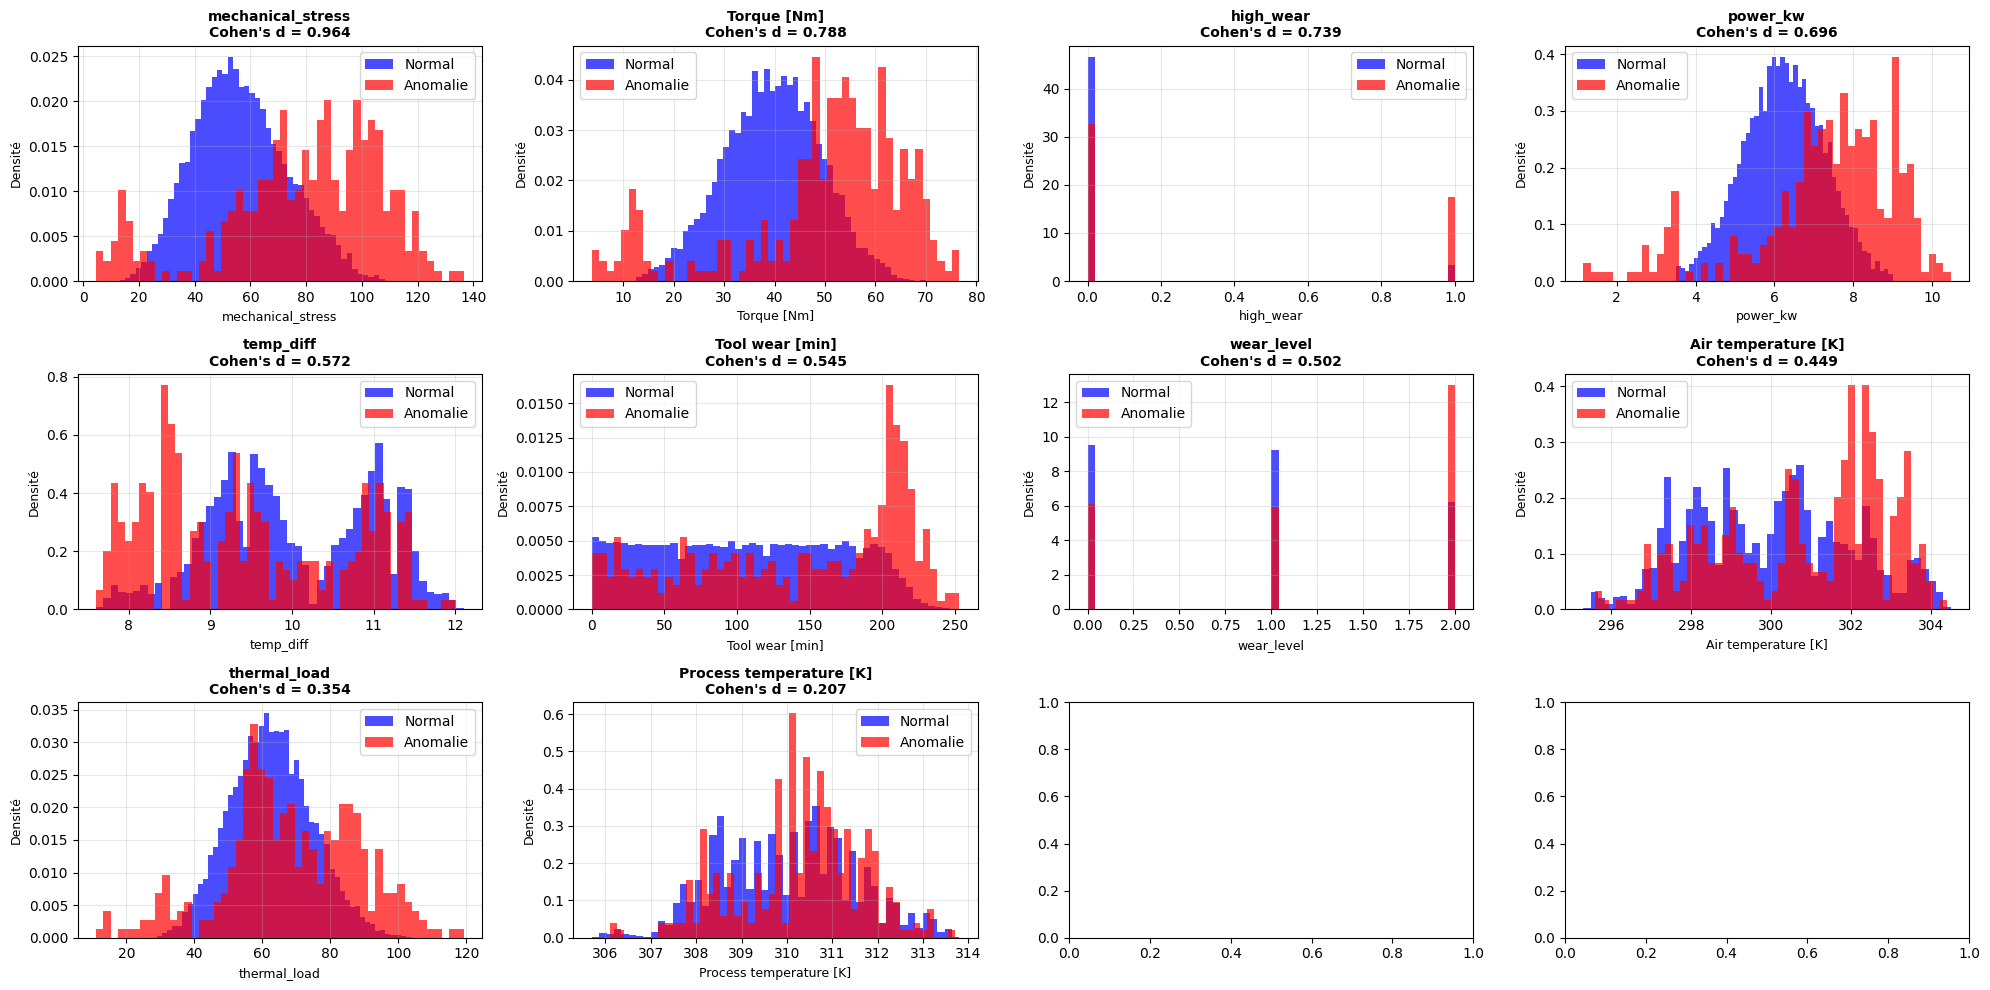

In [11]:

# VISUALISATION DES 10 MEILLEURES FEATURES
# Crée des histogrammes comparatifs pour visualiser la discrimination
# entre états normaux et anomalies pour chaque feature.
# Affiche également le Cohen's d pour quantifier la séparation
# Plus la séparation entre bleu (normal) et rouge (anomalie) est grande,
# meilleure est la feature pour détecter les anomalies

top_features = df_results.head(10)['feature'].tolist()

fig, axes = plt.subplots(3, 4, figsize=(20, 10))
axes = axes.ravel()

for i, feature in enumerate(top_features):
    # Histogrammes
    axes[i].hist(df_normal[feature], bins=50, alpha=0.7, label='Normal', 
                 color='blue', density=True)
    axes[i].hist(df_anomaly[feature], bins=50, alpha=0.7, label='Anomalie', 
                 color='red', density=True)
    
    # Cohen's d
    cohens_d = df_results[df_results['feature'] == feature]['cohens_d'].values[0]
    
    axes[i].set_title(f'{feature}\nCohen\'s d = {cohens_d:.3f}', 
                     fontweight='bold', fontsize=10)
    axes[i].set_xlabel(feature, fontsize=9)
    axes[i].set_ylabel('Densité', fontsize=9)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Correlation features et Target**


 CORRÉLATIONS (valeur absolue) :
--------------------------------------------------
mechanical_stress                0.2298
high_wear                        0.1920
Torque [Nm]                      0.1913
power_kw                         0.1760
temp_diff                        0.1117
Tool wear [min]                  0.1054
wear_level                       0.0932
thermal_load                     0.0856
Air temperature [K]              0.0826
speed_torque_ratio               0.0516
Rotational speed [rpm]           0.0442
Process temperature [K]          0.0359
Type_L                           0.0356
Type_H                           0.0239
Type_M                           0.0224


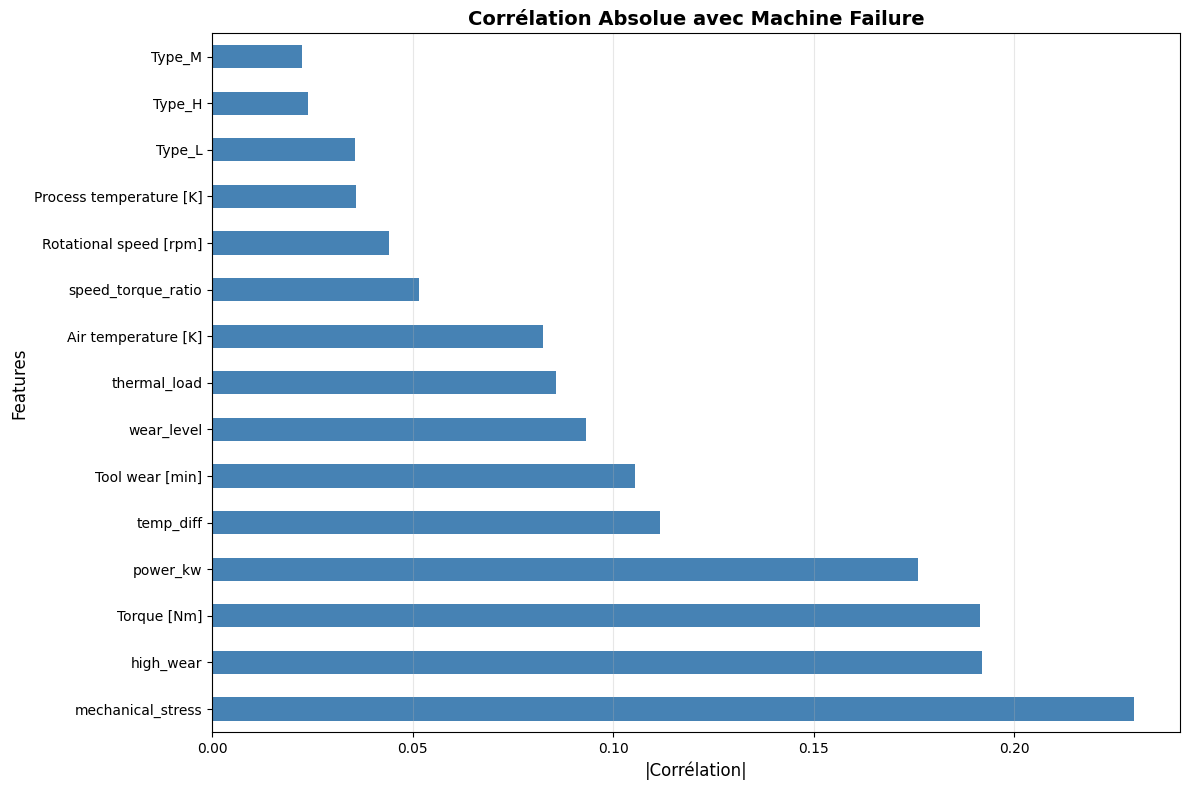

In [12]:

# ANALYSE DE CORRÉLATION : FEATURES vs CIBLE
# Calcule la corrélation de Pearson entre chaque feature et la variable cible
#  Une corrélation élevée indique que la feature est fortement liée à la présence d'anomalies.
# Visualise ces corrélations sous forme de graphique en barres

correlations = df_encoded[features_for_autoencoder + ['Machine failure']].corr()['Machine failure'].drop('Machine failure')
correlations_abs = correlations.abs().sort_values(ascending=False)

print("\n CORRÉLATIONS (valeur absolue) :")
print("-"*50)
for feature, corr in correlations_abs.items():
    print(f"{feature:<30} {corr:>8.4f}")

# Visualiser
plt.figure(figsize=(12, 8))
correlations_abs.plot(kind='barh', color='steelblue')
plt.title('Corrélation Absolue avec Machine Failure', fontsize=14, fontweight='bold')
plt.xlabel('|Corrélation|', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

**RECOMMANDATION FINALE :  Feature à  conserver**

In [13]:

# RECOMMANDATION FINALE : FEATURES à conserver
# Sélectionne les TOP-6 features selon le Cohen's d 
# Ces features seront utilisées pour entraîner les modèles finaux car elles offrent le meilleur compromis entre simplicité et performance

top_n = 6
top_n_features = df_results.head(top_n)['feature'].tolist()

print(f"\n TOP {top_n} FEATURES RECOMMANDÉES :")
print("="*60)
for i, feat in enumerate(top_n_features, 1):
    cohens_d = df_results[df_results['feature'] == feat]['cohens_d'].values[0]
    corr = correlations_abs[feat]
    print(f"{i:2d}. {feat:<30} | Cohen's d: {cohens_d:.3f} | |Corr|: {corr:.4f}")

print("\n" + "="*60)
print(" ANALYSE TERMINÉE !")
print("="*60)


 TOP 6 FEATURES RECOMMANDÉES :
 1. mechanical_stress              | Cohen's d: 0.964 | |Corr|: 0.2298
 2. Torque [Nm]                    | Cohen's d: 0.788 | |Corr|: 0.1913
 3. high_wear                      | Cohen's d: 0.739 | |Corr|: 0.1920
 4. power_kw                       | Cohen's d: 0.696 | |Corr|: 0.1760
 5. temp_diff                      | Cohen's d: 0.572 | |Corr|: 0.1117
 6. Tool wear [min]                | Cohen's d: 0.545 | |Corr|: 0.1054

 ANALYSE TERMINÉE !


In [14]:
df_results

feature  mean_normal  mean_anomaly    diff_pct  cohens_d  \
11        mechanical_stress    56.485026     78.919895   39.718259  0.963846   
3               Torque [Nm]    39.629655     50.168142   26.592425  0.787855   
9                 high_wear     0.066660      0.348083  422.177944  0.739288   
5                  power_kw     6.244088      7.282283   16.626856  0.696088   
6                 temp_diff    10.021571      9.403835   -6.164068  0.571965   
4           Tool wear [min]   106.693717    143.781711   34.761179  0.545171   
8                wear_level     0.868544      1.274336   46.721044  0.502483   
0       Air temperature [K]   299.973999    300.886431    0.304170  0.449140   
10             thermal_load    62.604540     68.486300    9.395101  0.353579   
1   Process temperature [K]   309.995570    310.290265    0.095064  0.206573   
13                   Type_L     0.596729      0.693215   16.169183  0.202520   
2    Rotational speed [rpm]  1540.260014   1496.486726   -2.841942  0.147475   
12                   Type_H     0.101646      0.061947  -39.056107  0.145151   
14                   Type_M     0.301625      0.244838  -18.827125  0.127603   
7        speed_torque_ratio    41.604328     48.032580   15.450923  0.116467   

          p_value  significant  
11  5.766052e-120         True  
3    4.573805e-83         True  
9    1.286257e-83         True  
5    2.044216e-70         True  
6    4.018489e-29         True  
4    3.976076e-26         True  
8    1.011931e-20         True  
0    1.354800e-16         True  
10   9.557703e-18         True  
1    3.240058e-04         True  
13   3.639160e-04         True  
2    9.853543e-06         True  
12   1.677280e-02         True  
14   2.488083e-02         True  
7    2.497813e-07         True

## Entrainement des autoencodeurs

In [15]:

# AUTOENCODEUR DENSE - INITIALISATION DU MODÈLE

# Dans cette section, nous voulons construire et entraîner un autoencodeur (AE) sur les features optimisées pour détecter les anomalies.
# Le principe est le suivant :
# - L'autoencodeur apprend à reconstruire les données NORMALES
# - Anomalies = Données avec erreur de reconstruction élevée
# - On entraîne uniquement sur les données normales
# 
# Architecture Globale :
# Input (6 features) -> Dense(8) -> Dense(4) -> Dense(2) [latent]-> Dense(4) -> Dense(8) -> Output (6)

from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

print("="*60)
print("AUTOENCODEUR DENSE - FEATURES OPTIMISÉES")
print("="*60)




selected_features = [
    'Tool wear [min]',
    'temp_diff',
    'power_kw',             # Features sélectionnéesplus haut(Top 6)
    'high_wear',
    'Torque [Nm]',
    'mechanical_stress'

]

print(f"\nFeatures sélectionnées : {len(selected_features)}")
for i, feat in enumerate(selected_features, 1):
    cohens_d = df_results[df_results['feature'] == feat]['cohens_d'].values[0]
    print(f"   {i}. {feat:<30} (Cohen's d = {cohens_d:.3f})")

# Créer X et y
X_optimized = df_encoded[selected_features].values
y = df_encoded['Machine failure'].values

print(f"\n Dataset optimisé :")
print(f"   X shape : {X_optimized.shape}")
print(f"   Features : {X_optimized.shape[1]} (au lieu de 15)")
print(f"   Réduction : {(1 - X_optimized.shape[1]/15)*100:.1f}%")

AUTOENCODEUR DENSE - FEATURES OPTIMISÉES

Features sélectionnées : 6
   1. Tool wear [min]                (Cohen's d = 0.545)
   2. temp_diff                      (Cohen's d = 0.572)
   3. power_kw                       (Cohen's d = 0.696)
   4. high_wear                      (Cohen's d = 0.739)
   5. Torque [Nm]                    (Cohen's d = 0.788)
   6. mechanical_stress              (Cohen's d = 0.964)

 Dataset optimisé :
   X shape : (10000, 6)
   Features : 6 (au lieu de 15)
   Réduction : 60.0%


**NORMALISATION**

In [16]:

# NORMALISATION DES DONNÉES

# StandardScaler permet de centrer et réduire les données (moyenne=0, écart-type=1)
# Opérations réalisées :
# 1. Fit sur les données normales seulement (afin d'éviter la fuite d'information)
# 2. Transforme l'ensemble du dataset
# 3. Sépare train (80%) / validation (20%) sur les données normales

# Les anomalies ne sont pas utilisées pour l'entraînement, mais uniquement pour l'évaluation finale

scaler_opt = StandardScaler()
X_scaled_opt = scaler_opt.fit_transform(X_optimized)

# Séparer normaux pour entraînement
X_normal_opt = X_scaled_opt[y == 0]

# Split train/val
X_train_opt, X_val_opt = train_test_split(X_normal_opt, test_size=0.2, random_state=42)

print(f"\n Données préparées :")
print(f"   Train : {X_train_opt.shape}")
print(f"   Validation : {X_val_opt.shape}") 


 Données préparées :
   Train : (7728, 6)
   Validation : (1933, 6)


In [17]:

# Fixation des seeds(Python, NumPy, TensorFlow) pour éviter la variabilitédes résultats entre exécutions

import numpy as np
import tensorflow as tf
import random

SEED = 42
# 1. Python 
random.seed(SEED)
# 2. NumPy
np.random.seed(SEED)
# 3. TensorFlow
tf.random.set_seed(SEED)
# 4. Pour reproductibilité complète 
import os
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'
print("Seeds fixés pour reproductibilité")

Seeds fixés pour reproductibilité


In [18]:

# PARAMÈTRES DE L'ARCHITECTURE ET RÉGULARISATION

# Gestion des Hyperparamètres clés de l'autoencodeur dense :ffd 
# Régularisation (évite l'overfitting) :
# - Dropout : Désactive aléatoirement 30% des neurones pendant l'entraînement
# - L1 : Pénalise les gros poids (sparsité) = compression forte
# - L2 : Pénalise les poids élevés (lissage) = généralisation
# 
# Seed : Assure la reproductibilité des initialisations aléatoires

input_dim_opt = X_optimized.shape[1]  #Nombre de features en entrée
encoding_dim = 2  #Dimension de l'espace latent
dropout_rate = 0.3 #Taux de dropout
l1_reg = 1e-5 
l2_reg = 0.001
print(f"\n Architecture :")
print(f"   Input : {input_dim_opt} features")
print(f"   Encoding dim : {encoding_dim}")
print(f"   Dropout : {dropout_rate}")
print(f"   L1 regularization : {l1_reg}")
print(f"   L2 regularization : {l2_reg}")
print(f"   Seed : {SEED}")


 Architecture :
   Input : 6 features
   Encoding dim : 2
   Dropout : 0.3
   L1 regularization : 1e-05
   L2 regularization : 0.001
   Seed : 42


In [19]:

# CONSTRUCTION ET ENTRAÎNEMENT DE L'AUTOENCODEUR
# Architecture Globale : Encoder (compression) + Bottleneck (espace latent) + Decoder (reconstruction)
 
# ENCODER : Compresse les 6 features en représentation latente (2 dimensions)
# - Couche 1 : 6 -> 8 neurones (ReLU) + Dropout(30%)
# - Couche 2 : 8 -> 4 neurones (ReLU) + Dropout(30%)
# - Couche latente : 4 -> 2 neurones (ReLU) - goulot d'étranglement

# DECODER : Reconstruit les 6 features originales à partir de la représentation latente
# - Couche 1 : 2 -> 4 neurones (ReLU)
# - Couche 2 : 4 -> 8 neurones (ReLU) avec BatchNormalization
# - Couche 3 : 8 -> 8 neurones (ReLU) avec BatchNormalization
# - Output : 8 -> 6 neurones (Linear) - reconstruction sans activation
 
# Callbacks :
# - EarlyStopping : Arrête si validation_loss ne s'améliore pas pendant 30 epochs
# - ReduceLROnPlateau : Réduit le learning rate si la val_loss stagne

input_layer = keras.layers.Input(shape=(input_dim_opt,))

# ENCODER
encoded = keras.layers.Dense(8, activation='relu', 
                             kernel_regularizer=regularizers.l2(l2_reg))(input_layer)
encoded = Dropout(dropout_rate,seed=SEED)(encoded)

encoded = keras.layers.Dense(4, activation='relu',
                             kernel_regularizer=regularizers.l2(l2_reg))(encoded)
encoded = Dropout(dropout_rate,seed=SEED)(encoded)

# Couche latente
encoded = keras.layers.Dense(encoding_dim, activation='relu',
                             activity_regularizer=regularizers.l1(l1_reg),
                             kernel_regularizer=regularizers.l2(l2_reg),name='espace_latent')(encoded)

#  DECODER
decoded = keras.layers.Dense(4, activation='relu',
                             )(encoded)

decoded = keras.layers.BatchNormalization()(decoded)


decoded = keras.layers.Dense(8, activation='relu',
                             )(decoded)
                        
decoded = keras.layers.BatchNormalization()(decoded)

decoded = keras.layers.Dense(input_dim_opt, activation='linear')(decoded)

# MODÈLE COMPLET 
autoencoder_opt = keras.Model(input_layer, decoded)
autoencoder_opt.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse')

print("\n" + "="*60)
print("ENTRAÎNEMENT")
print("="*60)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)


# Entraîner
history_opt = autoencoder_opt.fit(
    X_train_opt, X_train_opt,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_opt, X_val_opt),
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print(f"\n Entraînement terminé !")
print(f"   Meilleure val_loss : {min(history_opt.history['val_loss']):.6f}")


ENTRAÎNEMENT
Epoch 1/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1.2224 - val_loss: 0.8306 - learning_rate: 0.0010
Epoch 2/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.7971 - val_loss: 0.6635 - learning_rate: 0.0010
Epoch 3/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7472 - val_loss: 0.6132 - learning_rate: 0.0010
Epoch 4/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6954 - val_loss: 0.5927 - learning_rate: 0.0010
Epoch 5/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6673 - val_loss: 0.5489 - learning_rate: 0.0010
Epoch 6/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6443 - val_loss: 0.5507 - learning_rate: 0.0010
Epoch 7/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6364 - val_loss: 0.5353 - learning_rate: 0.0010
Epoch 8/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6241 - val_loss: 0.5319 - learning_rate: 0.0010
Epoch 9/200
242/242 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.6146 - val_loss: 0.5264 - learning_

In [20]:

# SAUVEGARDE DU MODÈLE
# Enregistre :
# 1. autoencoder_opt.keras : Le modèle entraîné (poids + architecture)
# 2. scaler_opt.pkl : Le StandardScaler pour normaliser les données futures
# Ces fichiers seront utilisés pour les prédictions en production

import joblib 
autoencoder_opt.save("models/autoencodeur/autoencoder_opt.keras")
joblib.dump(scaler_opt, 'models/autoencodeur/scaler_opt.pkl')

['models/autoencodeur/scaler_opt.pkl']

**ÉVALUATION**

In [21]:

# ÉVALUATION Avec les ERREURS DE RECONSTRUCTION

# Calcule l'erreur MSE (Mean Squared Error) pour chaque instance :
# MSE = moyenne( (données_originales - données_reconstruites)² )
 
#Petite Interprétation de nis résultats :
# - Données normales : MSE faible (le modèle les reconstruit bien)
# - Données anomales : MSE élevé (le modèle ne sait pas les reconstruire)
# - La différence de ratio montre la discrimination du modèle

# Prédictions
reconstructions_opt = autoencoder_opt.predict(X_scaled_opt, verbose=0)
mse_opt = np.mean(np.square(X_scaled_opt - reconstructions_opt), axis=1)

mse_normal_opt = mse_opt[y == 0]
mse_anomaly_opt = mse_opt[y == 1]

print(f"\n Erreurs de reconstruction :")
print(f"   Normaux - Moyenne : {mse_normal_opt.mean():.6f}")
print(f"   Anomalies - Moyenne : {mse_anomaly_opt.mean():.6f}")
print(f"   Ratio : {mse_anomaly_opt.mean() / mse_normal_opt.mean():.2f}x")


 Erreurs de reconstruction :
   Normaux - Moyenne : 0.256782
   Anomalies - Moyenne : 0.922678
   Ratio : 3.59x


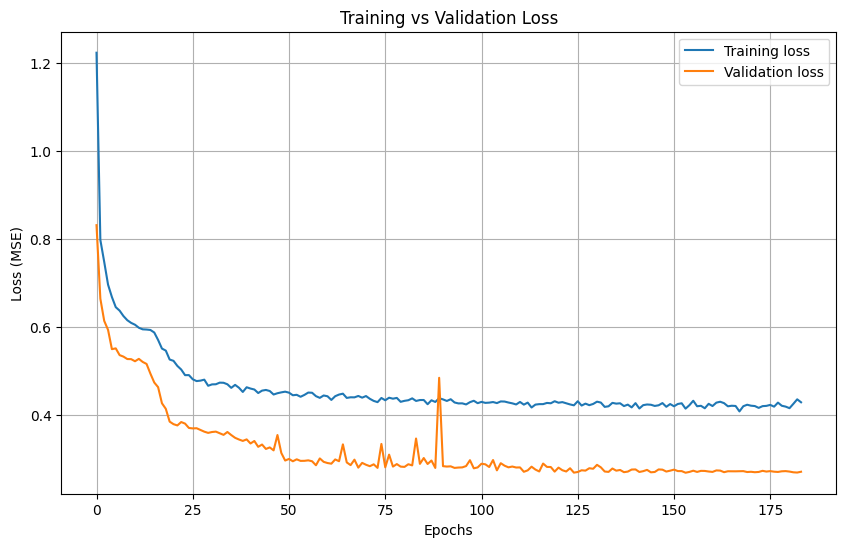

In [22]:

# VISUALISATION DES COURBES D'ENTRAÎNEMENT
# Trace la perte d'entraînement et de validation au fil des epochs
# 
# Interprétation :
# - Les deux courbes doivent converger (pas d'overfitting)
# - Si training << validation : overfitting (régularisation insuffisante)
# - Si training >> validation : underfitting (modèle trop simple)

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history_opt.history['loss'], label='Training loss')
plt.plot(history_opt.history['val_loss'], label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

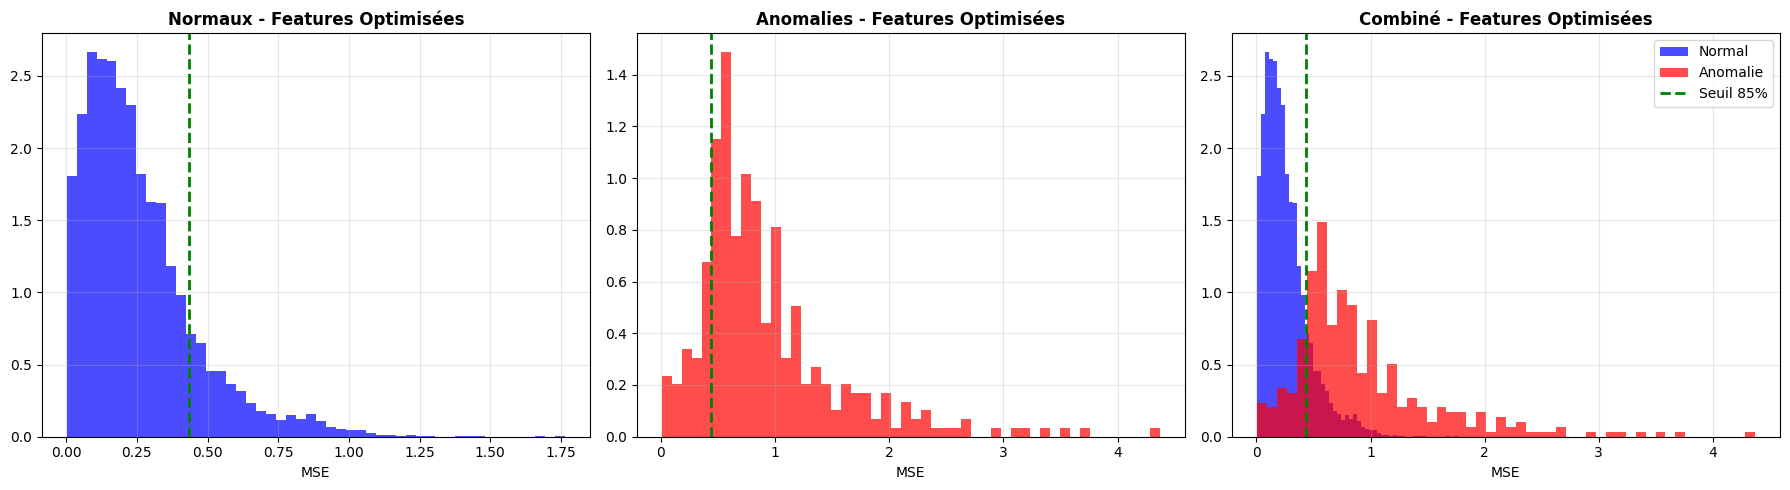

In [23]:

# VISUALISATION DES DISTRIBUTIONS MSE

# Affiche 3 histogrammes :
# 1. Erreurs des données NORMALES (histogramme seul)
# 2. Erreurs des données ANOMALES (histogramme seul)
# 3. Superposition : Bleu (normal) + Rouge (anomalie) + Seuil vert (85e percentile)
 
# La séparation claire entre les deux distributions indique une bonne capacité de détection d'anomalies

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].hist(mse_normal_opt, bins=50, alpha=0.7, color='blue', density=True)
axes[0].axvline(np.percentile(mse_normal_opt, 85), color='green', linestyle='--', linewidth=2)
axes[0].set_title('Normaux - Features Optimisées', fontweight='bold')
axes[0].set_xlabel('MSE')
axes[0].grid(True, alpha=0.3)

axes[1].hist(mse_anomaly_opt, bins=50, alpha=0.7, color='red', density=True)
axes[1].axvline(np.percentile(mse_normal_opt, 85), color='green', linestyle='--', linewidth=2)
axes[1].set_title('Anomalies - Features Optimisées', fontweight='bold')
axes[1].set_xlabel('MSE')
axes[1].grid(True, alpha=0.3)

axes[2].hist(mse_normal_opt, bins=50, alpha=0.7, label='Normal', color='blue', density=True)
axes[2].hist(mse_anomaly_opt, bins=50, alpha=0.7, label='Anomalie', color='red', density=True)
axes[2].axvline(np.percentile(mse_normal_opt, 85), color='green', linestyle='--', linewidth=2, label='Seuil 85%')
axes[2].set_title('Combiné - Features Optimisées', fontweight='bold')
axes[2].set_xlabel('MSE')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Optimisation seuil**

In [24]:

# OPTIMISATION DU SEUIL DE DÉCISION

# Teste différents seuils (percentiles) pour trouver le meilleur équilibre
# entre Recall et Precision :
 
# Recall = Anomalies détectées / Anomalies réelles
# Precision = Bonnes détections / Total de détections
# F1 = Moyenne harmonique 
 
#  On teste percentiles 70-95% et on sélectionne le meilleur

print("\n" + "="*60)
print("OPTIMISATION DU SEUIL")
print("="*60)

for percentile in [70, 75, 80, 85, 90, 95]:
    threshold = np.percentile(mse_normal_opt, percentile)
    predictions = (mse_opt > threshold).astype(int)
    
    recall = recall_score(y, predictions)
    precision = precision_score(y, predictions)
    f1 = f1_score(y, predictions)
    
    print(f"Seuil {percentile:2d}% | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")




OPTIMISATION DU SEUIL
Seuil 70% | Recall: 0.923 | Precision: 0.097 | F1: 0.176
Seuil 75% | Recall: 0.912 | Precision: 0.113 | F1: 0.202
Seuil 80% | Recall: 0.894 | Precision: 0.136 | F1: 0.235
Seuil 85% | Recall: 0.850 | Precision: 0.166 | F1: 0.277
Seuil 90% | Recall: 0.767 | Precision: 0.212 | F1: 0.332
Seuil 95% | Recall: 0.587 | Precision: 0.292 | F1: 0.390



RÉSULTATS FINAUX (Seuil 80%)
              precision    recall  f1-score   support

      Normal       1.00      0.80      0.89      9661
    Anomalie       0.14      0.89      0.24       339

    accuracy                           0.80     10000
   macro avg       0.57      0.85      0.56     10000
weighted avg       0.97      0.80      0.86     10000



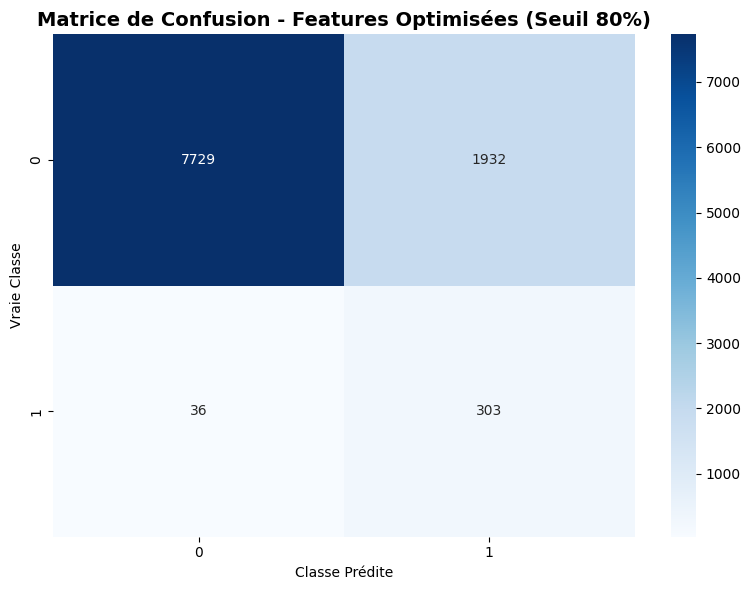


 OPTIMISATION TERMINÉE !


In [25]:

# RÉSULTATS FINAUX DE L'AUTOENCODEUR

# Avec le seuil optimal (80e percentile) :
# 1. Classification Report : Affiche Precision, Recall, F1-score
# 2. Matrice de Confusion 
#    Interprétation : Diagonale bleu foncé = bonnes prédictions

best_percentile = 80
threshold_best = np.percentile(mse_normal_opt, best_percentile)
predictions_best = (mse_opt > threshold_best).astype(int)

print(f"\n" + "="*60)
print(f"RÉSULTATS FINAUX (Seuil {best_percentile}%)")
print("="*60)

print(classification_report(y, predictions_best, target_names=['Normal', 'Anomalie']))

cm = confusion_matrix(y, predictions_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Matrice de Confusion - Features Optimisées (Seuil {best_percentile}%)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Vraie Classe')
plt.xlabel('Classe Prédite')
plt.tight_layout()
plt.show()

print("\n OPTIMISATION TERMINÉE !")

## Extraction des représentations latentes

In [26]:

# EXTRACTION DE L'ESPACE LATENT (ENCODER)

# Créons un modèle 'encoder' qui prend l'entrée de l'autoencodeur et retourne la sortie de la couche nommée 'espace_latent'.
# Utilisé pour extraire des représentations basses-dimensionnelles qui résument le comportement du système.

from tensorflow import keras

# Modèle encodeur : entrée → espace latent
encoder = keras.Model(
    inputs=autoencoder_opt.input,
    outputs=autoencoder_opt.get_layer("espace_latent").output
)

# Affichons un résumé de l'encoder 
encoder.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ espace_latent (Dense)           │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102 (408.00 B)

 Trainable params: 102 (408.00 B)

 Non-trainable params: 0 (0.00 B)

In [27]:
 
# CALCUL DES REPRÉSENTATIONS LATENTES POUR TOUT LE DATASET

# Prédit la représentation latente 'Z' pour chaque instance du dataset
# Ces vecteurs seront utilisés pour :
# - Visualisation 2D (si encoding_dim=2)
# - Clustering non supervisé (KMeans, DBSCAN)

Z = encoder.predict(X_scaled_opt, verbose=0)
print("Espace latent :", Z.shape)

Espace latent : (10000, 2)


Visualisation Comparative de l'Espace Latent

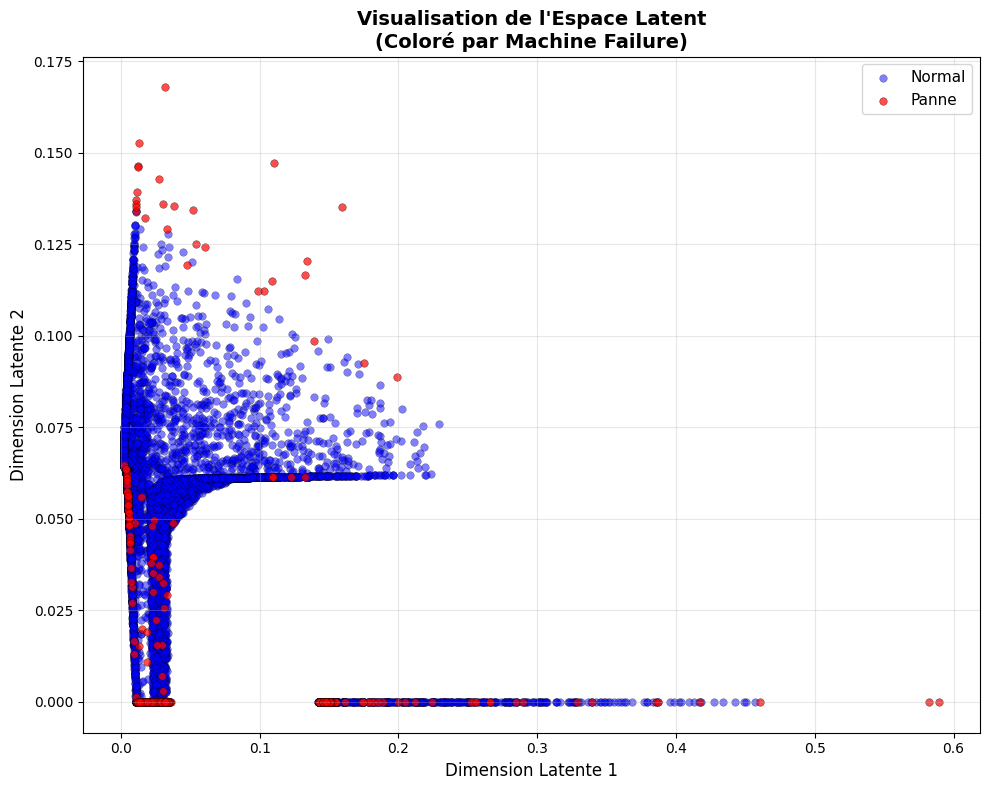

Points normaux (bleu) : 9661
Points en panne (rouge) : 339


In [28]:

# VISUALISATION DE L'ESPACE LATENT

# Trace les points latents en 2D et les colore selon la variable cible
# Permet d'apprécier si les pannes forment des zones séparées
# - Points bleus : en fonctionnement normal
# - Points rouges : pannes

import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 8))

# Séparer les points normaux et les pannes pour la légende
normal_mask = (y == 0)
failure_mask = (y == 1)

plt.scatter(Z[normal_mask, 0], Z[normal_mask, 1], 
           c='blue', alpha=0.5, s=30, label='Normal', edgecolors='k', linewidth=0.3)
plt.scatter(Z[failure_mask, 0], Z[failure_mask, 1], 
           c='red', alpha=0.7, s=30, label='Panne', edgecolors='k', linewidth=0.3)

plt.xlabel('Dimension Latente 1', fontsize=12)
plt.ylabel('Dimension Latente 2', fontsize=12)
plt.title('Visualisation de l\'Espace Latent\n(Coloré par Machine Failure)', 
         fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Statistiques rapides pour connaître les effectifs
print(f"Points normaux (bleu) : {normal_mask.sum()}")
print(f"Points en panne (rouge) : {failure_mask.sum()}")

### Clustering

In [29]:

# STANDARDISATION DE L'ESPACE LATENT
# Les algorithmes de clustering (KMeans, DBSCAN) sont sensibles à l'échelle
# StandardScaler centre et réduit chaque dimension pour améliorer la qualité
# du clustering et comparer plus facilement les distances

from sklearn.preprocessing import StandardScaler

scaler_latent = StandardScaler()
Z_scaled = scaler_latent.fit_transform(Z)

In [30]:

# CLUSTERING KMEANS SUR L'ESPACE LATENT

# Exécute KMeans pour segmenter l'espace latent en 3 clusters

from sklearn.cluster import KMeans

kmeans = KMeans(
    n_clusters=3,
    random_state=42,
    n_init=20
)

latent_clusters = kmeans.fit_predict(Z_scaled)


In [31]:

# ÉVALUATION DU CLUSTERING : SILHOUETTE SCORe
# Le score de silhouette (entre -1 et 1) indique la qualité du clustering :
# - proche de 1 : clusters bien séparés
# - proche de 0 : frontières floues
# - négatif : mauvaise séparation

from sklearn.metrics import silhouette_score

sil_score = silhouette_score(Z_scaled, latent_clusters)

print(f"Silhouette score : {sil_score:.3f}")

Silhouette score : 0.556


In [32]:

# CARACTÉRISATION DES CLUSTERS PAR ERREUR DE RECONSTRUCTION

# Calcule la MSE moyenne pour chaque cluster: plus la MSE est élevée, plus le cluster est susceptible de contenir des anomalies sévères.

cluster_mse = {}
for c in range(3):
    cluster_mse[c] = mse_opt[latent_clusters == c].mean()
    print(f"Cluster {c} | MSE moyenne = {cluster_mse[c]:.6f}")


# Trier par sévérité
sorted_clusters = sorted(cluster_mse, key=cluster_mse.get)
cluster_to_regime = {
    sorted_clusters[0]: "Normal",
    sorted_clusters[1]: "Dégradé",
    sorted_clusters[2]: "En panne"
}
regimes = np.array([cluster_to_regime[c] for c in latent_clusters])
print(cluster_to_regime)


Cluster 0 | MSE moyenne = 0.240880
Cluster 1 | MSE moyenne = 0.320005
Cluster 2 | MSE moyenne = 0.477724
{0: 'Normal', 1: 'Dégradé', 2: 'En panne'}


#### Vérification avec la vérité terrain

In [33]:

# CONSTRUCTION D'UN DATAFRAME POUR ANALYSE DES RÉGIMES
# Concatène les coordonnées latentes, le cluster, le régime assigné, le "Machine failure" et la MSE 

df_latent = pd.DataFrame(Z, columns=[f"z{i}" for i in range(Z.shape[1])])
df_latent["cluster"] = latent_clusters
df_latent["regime"] = regimes
df_latent["Machine failure"] = y
df_latent["mse"] = mse_opt

df_latent.groupby(["regime", "Machine failure"]).size()


regime    Machine failure
Dégradé   0                  1875
          1                   150
En panne  0                   827
          1                   121
Normal    0                  6959
          1                    68
dtype: int64

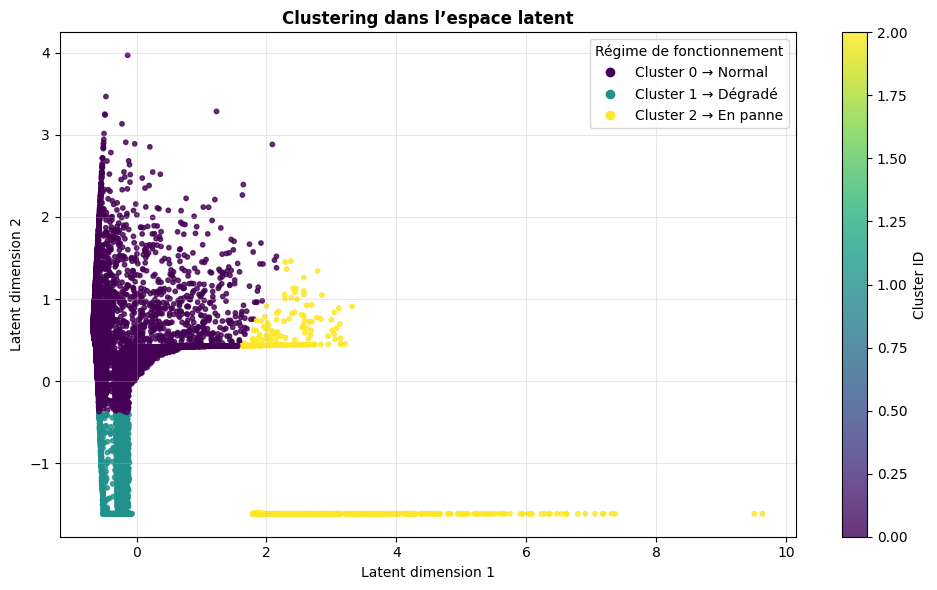

In [35]:

# VISUALISATION DU CLUSTERING DANS L'ESPACE LATENT


# Affiche les clusters (colorés numériquement) et ajoute une légende indiquant l'interprétation métier (Normal / Dégradé / En panne)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

plt.figure(figsize=(10, 6))

scatter = plt.scatter(
    Z_scaled[:, 0],
    Z_scaled[:, 1],
    c=latent_clusters,
    cmap="viridis",
    s=10,
    alpha=0.8
)

plt.title("Clustering dans l’espace latent", fontweight="bold")
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.grid(alpha=0.3)

# Colorbar (clusters numériques)
cbar = plt.colorbar(scatter)
cbar.set_label("Cluster ID")

# LÉGENDE MÉTIER (régimes)


unique_clusters = np.unique(latent_clusters)

legend_elements = [
    Line2D(
        [0], [0],
        marker='o',
        color='w',
        label=f"Cluster {c} → {cluster_to_regime[c]}",
        markerfacecolor=scatter.cmap(scatter.norm(c)),
        markersize=8
    )
    for c in unique_clusters
]

plt.legend(
    handles=legend_elements,
    title="Régime de fonctionnement",
    loc="best",
    frameon=True
)

plt.tight_layout()
plt.show()

#### DBSCAN

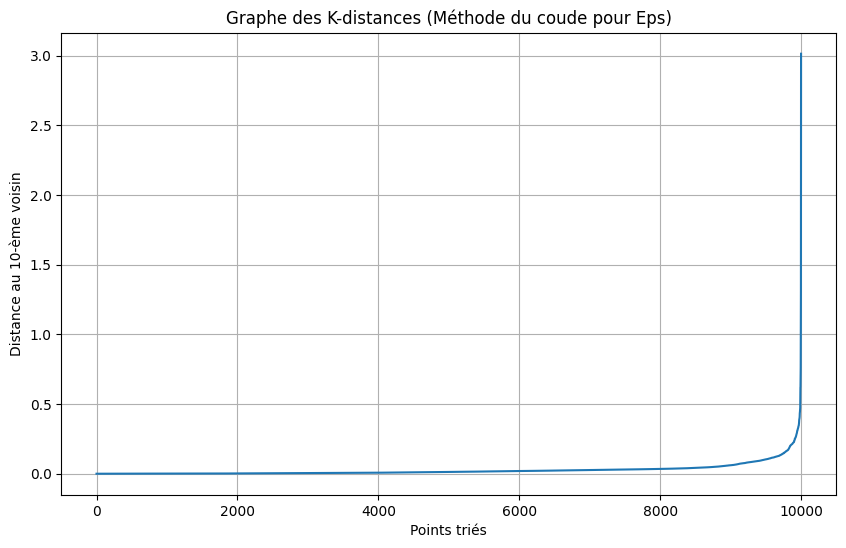

Instruction : Repérez la valeur en ordonnée où la courbe commence à monter brutalement (le coude).


In [36]:

# DBSCAN - CHOIX DU PARAMÈTRE EPS (MÉTHODE DU COUDE)

#Notre Objectif : Estimer une valeur d'eps cohérente pour DBSCAN en regardant la courbe des distances au k-ème voisin (k = min_samples).
# Un "coude" sur la courbe indique une distance où la densité chute, ce qui est un bon candidat pour eps.



from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Configuration
min_samples = 10

# Calcul des voisins les plus proches
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(Z_scaled)
distances, indices = neighbors_fit.kneighbors(Z_scaled)

# Tri des distances pour afficher le graphe
distances = np.sort(distances[:, min_samples-1], axis=0)

plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Graphe des K-distances (Méthode du coude pour Eps)')
plt.xlabel('Points triés')
plt.ylabel(f'Distance au {min_samples}-ème voisin')
plt.grid(True)
plt.show()
print("Instruction : Repérez la valeur en ordonnée où la courbe commence à monter brutalement (le coude).")

In [37]:

# EXÉCUTION DE DBSCAN

# Après analyse visuelle du graphe K-distances, définissez `eps_value`.
# - Si eps est trop petit : cela veut dire qu'il y a beaucoup de bruit et peu de clusters
# - Si eps est trop grand : les clusters fusionnent et on perd la granularité
#
# Ici, on initialise eps à une valeur par défaut (à ajuster manuellement)

# PARAMÈTRE A AJUSTER 
eps_value = 0.5


print(f"Lancement de DBSCAN avec eps={eps_value} et min_samples={min_samples}...")
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
dbscan_clusters = dbscan.fit_predict(Z_scaled)

# Analyse rapide des résultats
n_clusters_ = len(set(dbscan_clusters)) - (1 if -1 in dbscan_clusters else 0)
n_noise_ = list(dbscan_clusters).count(-1)

print(f'  -> Nombre de clusters estimés : {n_clusters_}')
print(f'  -> Nombre de points de bruit (-1) : {n_noise_}')

Lancement de DBSCAN avec eps=0.5 et min_samples=10...
  -> Nombre de clusters estimés : 2
  -> Nombre de points de bruit (-1) : 5


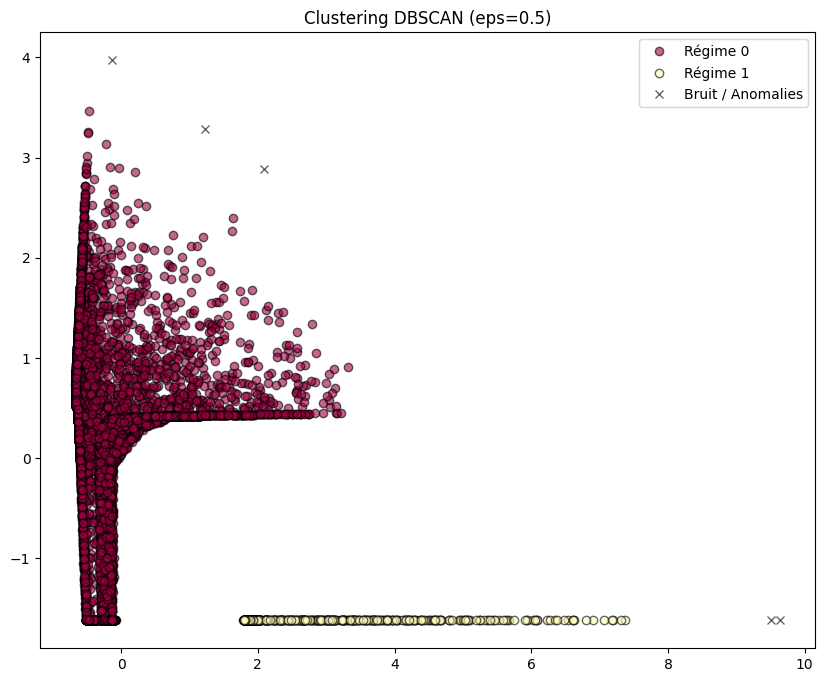

In [38]:

# VISUALISATION DES RÉSULTATS DBSCAN
# Affiche les clusters identifiés par DBSCAN. DBSCAN marque les points
# de faible densité comme bruit (-1). On attribue un marqueur différent
# et une couleur noire aux points de bruit pour faciliter l'interprétation.

plt.figure(figsize=(10, 8))

unique_labels = set(dbscan_clusters)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Bruit en Noir
        col = [0, 0, 0, 1]
        label = "Bruit / Anomalies"
        marker = 'x'
    else:
        label = f"Régime {k}"
        marker = 'o'

    class_member_mask = (dbscan_clusters == k)

    xy = Z_scaled[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], marker, markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6, label=label, alpha=0.6)

plt.title(f'Clustering DBSCAN (eps={eps_value})')
plt.legend()
plt.show()

In [39]:

# CARACTÉRISATION DES RÉGIMES (DBSCAN)

# Pour chaque cluster retourné par DBSCAN (y compris -1 bruit),
# on calcule :
# - le Nombre d'éléments
# - MSE moyen (erreur de reconstruction)
# - Taux de pannes (Machine failure) pour évaluer la dangerosité
#
# Interprétation simple :
# - cluster == -1 : points isolés / anomalies non regroupées
# - avg_mse faible  : probablement NORMAL
# - avg_mse élevé   : DÉGRADÉ ou PANNE

import pandas as pd

# Création du DataFrame d'analyse
df_dbscan = pd.DataFrame(Z, columns=[f"z{i}" for i in range(Z.shape[1])])
df_dbscan["cluster"] = dbscan_clusters
df_dbscan["Machine failure"] = y
df_dbscan["mse"] = mse_opt

print("=== CARACTÉRISATION DES RÉGIMES (DBSCAN) ===")
print(f"{'Cluster':<15} | {'Count':<8} | {'MSE Moyen':<10} | {'Taux de Panne (%)':<20} | {'Interprétation probable'}")
print("-" * 85)

for c in sorted(unique_labels):
    mask = df_dbscan["cluster"] == c
    avg_mse = df_dbscan.loc[mask, "mse"].mean()
    fail_rate = df_dbscan.loc[mask, "Machine failure"].mean() * 100
    count = mask.sum()

    # Logique simple d'interprétation
    if c == -1:
        interp = "ANOMALIE (Non modélisé)"
    elif avg_mse < np.percentile(mse_opt, 80): # 
        interp = "NORMAL"
    else:
        interp = "DÉGRADÉ / PANNE"

    print(f"{c:<15} | {count:<8} | {avg_mse:.4f}     | {fail_rate:6.2f}%            | {interp}")

=== CARACTÉRISATION DES RÉGIMES (DBSCAN) ===
Cluster         | Count    | MSE Moyen  | Taux de Panne (%)    | Interprétation probable
-------------------------------------------------------------------------------------
-1              | 5        | 1.5982     | 100.00%            | ANOMALIE (Non modélisé)
0               | 9235     | 0.2614     |   2.36%            | NORMAL
1               | 760      | 0.4893     |  15.26%            | DÉGRADÉ / PANNE


# 3- Comparaison avec les méthodes classiques

## Isolation forest

In [40]:

# COMPARAISON - IMPORTS GLOBAUX POUR LES MÉTHODES CLASSIQUES

# Import des bibliothèques nécessaires pour faire des expérimentations avec des méthodes classiques d'anomalie : Isolation Forest, One-Class SVM, LOF


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [41]:

# PRÉPARATION DES DONNÉES POUR LES MÉTHODES CLASSIQUES

# Sélection des mêmes features optimisées que pour l'autoencodeur
# Normalisation : importante pour les méthodes basées sur la distance
# (SVM, LOF) et utile pour IsolationForest

features = ['Tool wear [min]','temp_diff','power_kw','high_wear','Torque [Nm]','mechanical_stress']

X = df[features]
y = df['Machine failure']  


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Données chargées : {X_scaled.shape}")
print(f"Répartition des classes : \n{y.value_counts()}")

Données chargées : (10000, 6)
Répartition des classes : 
Machine failure
0    9661
1     339
Name: count, dtype: int64


In [42]:

# ISOLATION FOREST - ENTRAÎNEMENT

# IsolationForest détecte les anomalies en entraînant des arbres qui isolent les observations anormales plus rapidement.
# Paramètres clés utilisés :
# - n_estimators : nombre d'arbres
# - max_samples : sous-échantillonnage par arbre (robustesse)
# - contamination : proportion attendue d'anomalies (estimée)

# Le modèle renvoie : +1 (normal) et -1 (anomalie)

iso_forest = IsolationForest(
    n_estimators=100,        # Nombre d'arbres
    max_samples=256,         # Échantillon par arbre (évite de "noyer" les anomalies)
    contamination=0.03,      # Proportion estimée d'anomalies
    random_state=42,
    n_jobs=-1                
)

# Entraînement et prédiction
print("Entraînement en cours...")
predictions_if = iso_forest.fit_predict(X_scaled)

print(" Entraînement terminé.")

Entraînement en cours...
 Entraînement terminé.


In [43]:

# SAUVEGARDE DU MODELE ISOLATION FOREST ET DU SCALER

# Sauvegarde du modèle et du scaler pour une réutilisation ultérieure (déploiement ou validation sur d'autres jeux de données)

import joblib
joblib.dump(iso_forest, 'models/isolation_forest/isolation_forest.pkl')
joblib.dump(scaler, 'models/isolation_forest/scaler.pkl')

print("Modèle et Scaler sauvegardés")



Modèle et Scaler sauvegardés


RÉSULTATS ISOLATION FOREST
Matrice de Confusion :
 [[9503  158]
 [ 197  142]]

- Pannes détectées (TP) : 142
- Pannes ratées (FN)    : 197
- Fausses alarmes (FP)  : 158


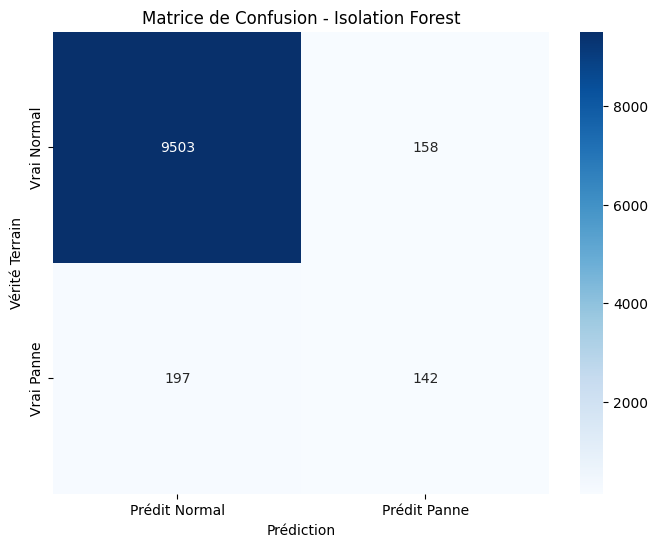

ROC AUC Score : 0.9196


In [44]:

# ISOLATION FOREST - ÉVALUATION

# Conversion des prédictions pour correspondre aux labels du dataset :
# IsolationForest -> -1 = anomalie, 1 = normal
# Notre convention       -> 1 = anomalie, 0 = normal

# Conversion des prédictions pour match vos labels :
y_pred_if = np.where(predictions_if == -1, 1, 0)

# Matrice de Confusion et métriques
print("="*60)
print("RÉSULTATS ISOLATION FOREST")
print("="*60)
cm = confusion_matrix(y, y_pred_if)
print("Matrice de Confusion :\n", cm)

# Détails des éléments de la matrice
tn, fp, fn, tp = cm.ravel()
print(f"\n- Pannes détectées (TP) : {tp}")
print(f"- Pannes ratées (FN)    : {fn}")
print(f"- Fausses alarmes (FP)  : {fp}")

# Visualisation de la matrice
a = plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Prédit Normal', 'Prédit Panne'],
            yticklabels=['Vrai Normal', 'Vrai Panne'])
plt.title('Matrice de Confusion - Isolation Forest')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction')
plt.show()

# Score ROC AUC : on inverse le decision_function car valeur basse = anomalie
scores_if = iso_forest.decision_function(X_scaled)
auc = roc_auc_score(y, -scores_if)
print(f"ROC AUC Score : {auc:.4f}")

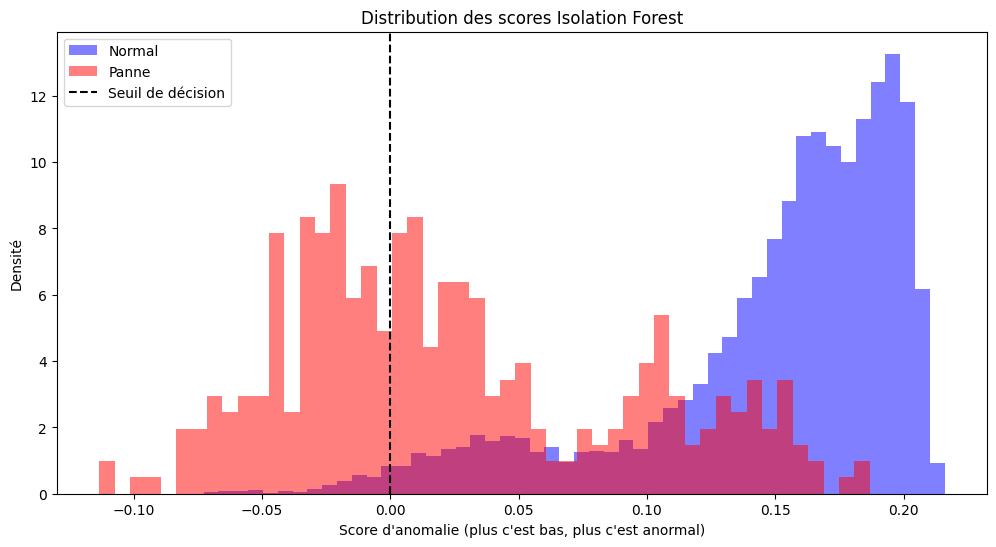

In [45]:

# ISOLATION FOREST - VISUALISATION DES SCORES

# Visualise la distribution des scores retournés par IsolationForest
# - scores bas -> plus anormal
# On superpose les distributions pour normaux et pannes

plt.figure(figsize=(12, 6))

# Histogramme des scores
plt.hist(scores_if[y==0], bins=50, alpha=0.5, label="Normal", color="blue", density=True)
plt.hist(scores_if[y==1], bins=50, alpha=0.5, label="Panne", color="red", density=True)

plt.axvline(0, color='k', linestyle='--', label="Seuil de décision")
plt.xlabel("Score d'anomalie (plus c'est bas, plus c'est anormal)")
plt.ylabel("Densité")
plt.title("Distribution des scores Isolation Forest")
plt.legend()
plt.show()

## One Class SVM

In [46]:

# ONE-CLASS SVM - IMPORTS

# Importations nécessaires pour One-Class SVM et métriques associées
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


In [47]:

# ONE-CLASS SVM - PRÉPARATION DES DONNÉES

# Utilise les mêmes features que précédemment et normalise les données.
# One-Class SVM est entraîné principalement sur les exemples normaux,
# mais ici nous l'entraînons globalement pour détecter les outliers.

features = ['Tool wear [min]','temp_diff','power_kw','high_wear','Torque [Nm]','mechanical_stress']

X = df[features]
y = df['Machine failure']  # 0=Normal, 1=Panne

# Normalisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Données chargées : {X_scaled.shape}")
print(f"Taux de pannes : {y.mean()*100:.2f}%")

Données chargées : (10000, 6)
Taux de pannes : 3.39%


In [48]:

# ONE-CLASS SVM - ENTRAÎNEMENT

# One-Class SVM apprend une frontière autour des données "normales".
# Paramètre : nu -> proportion maximale d'anomalies attendues.

ocsvm = OneClassSVM(
    kernel='rbf',
    gamma='auto',
    nu=0.03
)

print("Entraînement One-Class SVM en cours...")


# Entraînement
ocsvm.fit(X_scaled)

print(" Entraînement terminé")

Entraînement One-Class SVM en cours...
 Entraînement terminé


In [49]:

# SAUVEGARDE DU MODELE ONE-CLASS SVM

# Sauvegarde le modèle entraîné et le scaler utilisé pour la normalisation
# Cela permet de reproduire les prédictions en production ou sur d'autres jeux

import joblib
import os

os.makedirs('models/one_class_svm', exist_ok=True)

joblib.dump(ocsvm, 'models/one_class_svm/ocsvm.pkl')
joblib.dump(scaler, 'models/one_class_svm/scaler.pkl')

print(" Modèle One-Class SVM et Scaler sauvegardés dans models/one_class_svm/")

 Modèle One-Class SVM et Scaler sauvegardés dans models/one_class_svm/


In [50]:

# ONE-CLASS SVM - PREDICTION

# One-Class SVM retourne +1 pour normal, -1 pour anomalie
# Convertit en nos labels 0=Normal, 1=Panne

predictions_ocsvm = ocsvm.predict(X_scaled)

# Conversion pour correspondre à nos labels
# Nos labels : 0=Normal, 1=Panne
y_pred_ocsvm = np.where(predictions_ocsvm == -1, 1, 0)

print(f"Nombre d'anomalies détectées : {(y_pred_ocsvm == 1).sum()}")

Nombre d'anomalies détectées : 296


In [51]:

# ONE-CLASS SVM - ÉVALUATION

# Matrice de confusion et rapport de classification pour analyser le comportement du modèle sur les classes réelles

print("="*60)
print("RÉSULTATS ONE-CLASS SVM")
print("="*60)

cm_ocsvm = confusion_matrix(y, y_pred_ocsvm)
print("Matrice de Confusion :")
print(cm_ocsvm)

tn, fp, fn, tp = cm_ocsvm.ravel()
print(f"\n- Pannes détectées (TP) : {tp}")
print(f"- Pannes ratées (FN)    : {fn}")
print(f"- Fausses alarmes (FP)  : {fp}")

# Rapport complet
print("\n" + classification_report(y, y_pred_ocsvm, 
                                  target_names=['Normal', 'Panne']))

RÉSULTATS ONE-CLASS SVM
Matrice de Confusion :
[[9466  195]
 [ 238  101]]

- Pannes détectées (TP) : 101
- Pannes ratées (FN)    : 238
- Fausses alarmes (FP)  : 195

              precision    recall  f1-score   support

      Normal       0.98      0.98      0.98      9661
       Panne       0.34      0.30      0.32       339

    accuracy                           0.96     10000
   macro avg       0.66      0.64      0.65     10000
weighted avg       0.95      0.96      0.96     10000



In [52]:

# ONE-CLASS SVM - SCORES ET ROC AUC

# Récupération des scores bruts (decision_function)
# Plus le score est négatif, plus c'est une anomalie selon OCSVM

scores_ocsvm = ocsvm.decision_function(X_scaled)

# Calcul du ROC AUC (on inverse les scores)
auc_ocsvm = roc_auc_score(y, -scores_ocsvm)

print(f"ROC AUC Score : {auc_ocsvm:.4f}")
print(f"\nScore min (anomalie forte) : {scores_ocsvm.min():.4f}")
print(f"Score max (normal fort)    : {scores_ocsvm.max():.4f}")

ROC AUC Score : 0.8014

Score min (anomalie forte) : -18.2933
Score max (normal fort)    : 6.5689


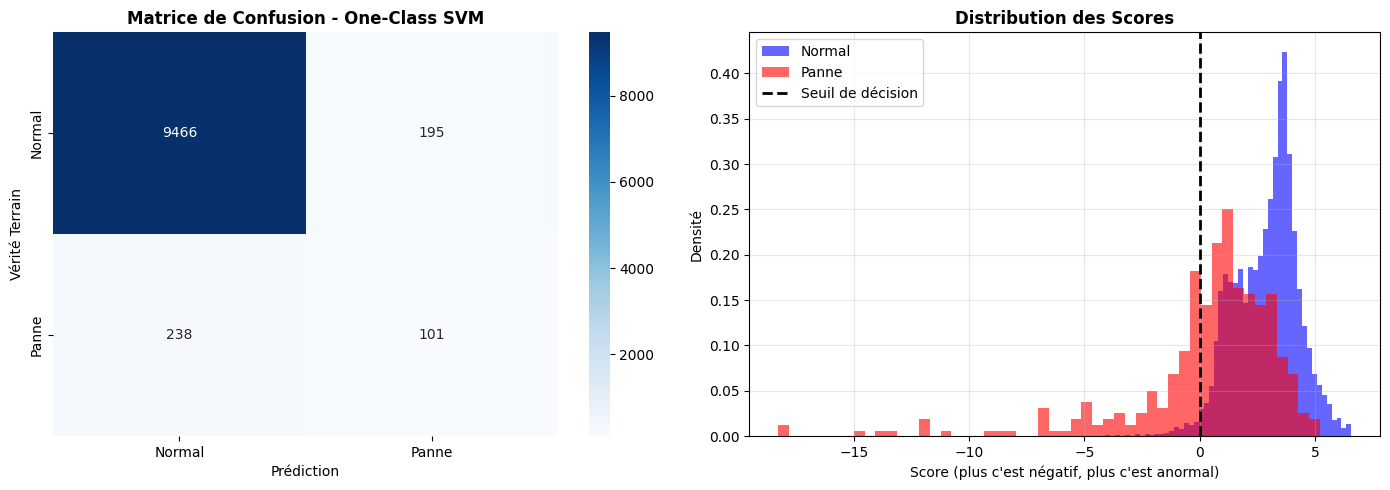

In [53]:

# ONE-CLASS SVM - VISUALISATIONS

# 1) Matrice de confusion
# 2) Distribution des scores : comparer la densité des scores pour les normaux et les pannes afin d'apprécier la séparation

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Matrice de confusion
sns.heatmap(cm_ocsvm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Normal', 'Panne'], 
            yticklabels=['Normal', 'Panne'])
axes[0].set_title('Matrice de Confusion - One-Class SVM', fontweight='bold')
axes[0].set_ylabel('Vérité Terrain')
axes[0].set_xlabel('Prédiction')

# Graphique 2 : Distribution des scores
axes[1].hist(scores_ocsvm[y==0], bins=50, alpha=0.6, 
             label='Normal', color='blue', density=True)
axes[1].hist(scores_ocsvm[y==1], bins=50, alpha=0.6, 
             label='Panne', color='red', density=True)
axes[1].axvline(0, color='k', linestyle='--', linewidth=2, 
                label='Seuil de décision')
axes[1].set_xlabel('Score (plus c\'est négatif, plus c\'est anormal)')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution des Scores', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Local Outlier Factor

In [54]:

# LOCAL OUTLIER FACTOR (LOF) - IMPORTS

# LOF est une méthode locale basée sur la densité pour détecter les outliers.
# elle nous est Utile pour repérer anomalies locales non visibles globalement.
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [55]:

# LOF - PRÉPARATION DES DONNÉES

# Utilise les mêmes features normalisées que pour les autres méthodes

features = ['Tool wear [min]','temp_diff','power_kw','high_wear','Torque [Nm]','mechanical_stress']

X = df[features]
y = df['Machine failure']  # 0=Normal, 1=Panne

# Normalisation (importante pour les méthodes basées sur la distance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Données chargées : {X_scaled.shape}")
print(f"Taux de pannes : {y.mean()*100:.2f}%")

Données chargées : (10000, 6)
Taux de pannes : 3.39%


In [56]:

# LOF - CALCUL ET PREDICTIONS

# LOF renvoie +1 pour normal et -1 pour anomalie (comme OCSVM)
# n_neighbors contrôle la taille de la voisinage local utilisé pour estimer la densité

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.03,
    n_jobs=-1
)

print("Calcul du LOF en cours...")

# fit_predict : entraîne et prédit en une seule étape
# Retourne : +1 (normal), -1 (anomalie)
predictions_lof = lof.fit_predict(X_scaled)

print("Calcul terminé")

Calcul du LOF en cours...
Calcul terminé


In [57]:

# LOF - SAUVEGARDE DU MODELE ET DU SCALER

# Sauvegarde du LOF 
os.makedirs('models/lof', exist_ok=True)
joblib.dump(lof, 'models/lof/lof.pkl')
joblib.dump(scaler, 'models/lof/scaler.pkl')
print("Modèle LOF et Scaler sauvegardés dans models/lof/")

Modèle LOF et Scaler sauvegardés dans models/lof/


In [58]:

# LOF - CONVERSION DES PRÉDICTIONS ET SCORES

# Convertit les prédictions LOF en étiquettes 0/1 et extrait les scores
# negative_outlier_factor_ : plus c'est négatif → plus c'est anormal

# Conversion pour correspondre à nos labels
# Nos labels sont: 0=Normal, 1=Panne
y_pred_lof = np.where(predictions_lof == -1, 1, 0)

# Extraction des scores LOF
# negative_outlier_factor_ : plus c'est négatif, plus c'est une anomalie
# On inverse le signe pour avoir : score élevé = anomalie
lof_scores = -lof.negative_outlier_factor_

print(f"Nombre d'anomalies détectées : {(y_pred_lof == 1).sum()}")
print(f"\nScore LOF min (normal) : {lof_scores.min():.4f}")
print(f"Score LOF max (anomalie forte) : {lof_scores.max():.4f}")
print(f"Score LOF moyen : {lof_scores.mean():.4f}")

Nombre d'anomalies détectées : 300

Score LOF min (normal) : 0.9433
Score LOF max (anomalie forte) : 2.5667
Score LOF moyen : 1.0399


In [59]:

# LOF - ÉVALUATION

# Matrice de confusion et rapport de classification
print("="*60)
print("RÉSULTATS LOCAL OUTLIER FACTOR (LOF)")
print("="*60)

cm_lof = confusion_matrix(y, y_pred_lof)
print("Matrice de Confusion :")
print(cm_lof)

tn, fp, fn, tp = cm_lof.ravel()
print(f"\n- Pannes détectées (TP) : {tp}")
print(f"- Pannes ratées (FN)    : {fn}")
print(f"- Fausses alarmes (FP)  : {fp}")

# Rapport complet
print("\n" + classification_report(y, y_pred_lof, 
                                  target_names=['Normal', 'Panne']))

RÉSULTATS LOCAL OUTLIER FACTOR (LOF)
Matrice de Confusion :
[[9452  209]
 [ 248   91]]

- Pannes détectées (TP) : 91
- Pannes ratées (FN)    : 248
- Fausses alarmes (FP)  : 209

              precision    recall  f1-score   support

      Normal       0.97      0.98      0.98      9661
       Panne       0.30      0.27      0.28       339

    accuracy                           0.95     10000
   macro avg       0.64      0.62      0.63     10000
weighted avg       0.95      0.95      0.95     10000



In [60]:

# LOF - ROC AUC ET STATISTIQUES PAR CLASSE

# Calcul du ROC AUC en utilisant les scores LOF continus
auc_lof = roc_auc_score(y, lof_scores)

print(f"ROC AUC Score : {auc_lof:.4f}")

# Statistiques par classe
print(f"\nScore LOF moyen pour les normaux : {lof_scores[y==0].mean():.4f}")
print(f"Score LOF moyen pour les pannes  : {lof_scores[y==1].mean():.4f}")

ROC AUC Score : 0.8218

Score LOF moyen pour les normaux : 1.0349
Score LOF moyen pour les pannes  : 1.1830


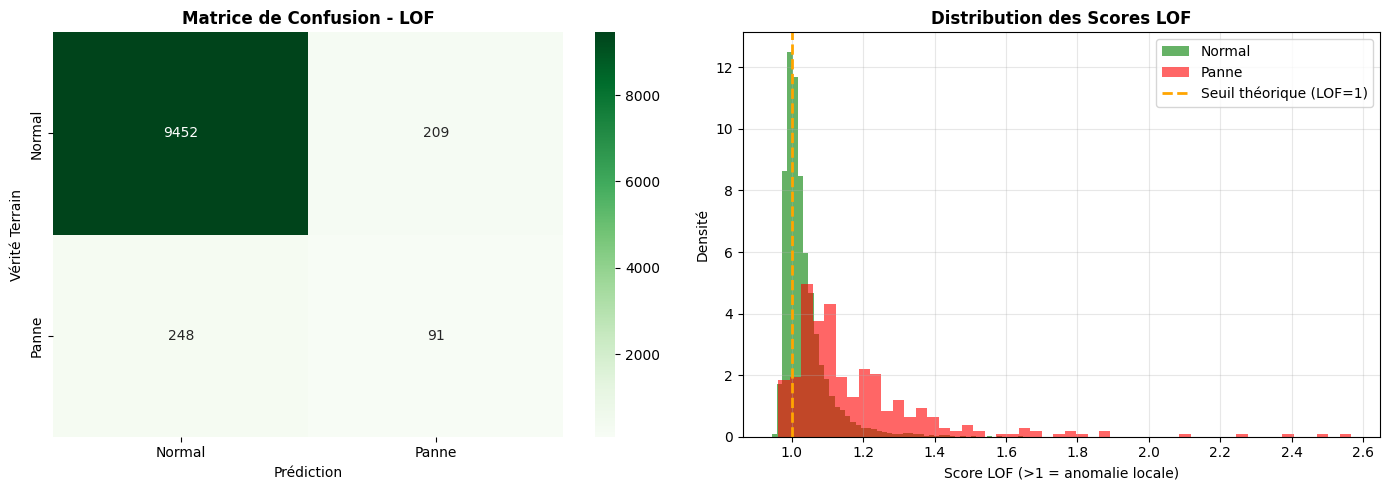

In [61]:

# LOF - VISUALISATION

# 1) Matrice de confusion
# 2) Distribution des scores LOF (valeur >1 indique anomalie locale)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Matrice de confusion
sns.heatmap(cm_lof, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Normal', 'Panne'], 
            yticklabels=['Normal', 'Panne'])
axes[0].set_title('Matrice de Confusion - LOF', fontweight='bold')
axes[0].set_ylabel('Vérité Terrain')
axes[0].set_xlabel('Prédiction')

# Graphique 2 : Distribution des scores LOF
axes[1].hist(lof_scores[y==0], bins=50, alpha=0.6, 
             label='Normal', color='green', density=True)
axes[1].hist(lof_scores[y==1], bins=50, alpha=0.6, 
             label='Panne', color='red', density=True)
axes[1].axvline(1.0, color='orange', linestyle='--', linewidth=2, 
                label='Seuil théorique (LOF=1)')
axes[1].set_xlabel('Score LOF (>1 = anomalie locale)')
axes[1].set_ylabel('Densité')
axes[1].set_title('Distribution des Scores LOF', fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## LSTM

In [83]:
#on recharge le dataset
import pandas as pd
df=pd.read_csv("ai4i2020.csv")

In [84]:
# Features physiques
df['power_kw'] = (df['Torque [Nm]'] * df['Rotational speed [rpm]']) / 9550
df['temp_diff'] = df['Process temperature [K]'] - df['Air temperature [K]']
df['speed_torque_ratio'] = df['Rotational speed [rpm]'] / (df['Torque [Nm]'] + 1)

# Features d'usure
max_wear = df['Tool wear [min]'].max()
df['wear_level'] = pd.cut(df['Tool wear [min]'], 
                          bins=[0, 80, 160, max_wear + 1],
                          labels=[0, 1, 2],
                          include_lowest=True)
df['wear_level'] = pd.to_numeric(df['wear_level'], errors='coerce').fillna(0).astype(int)

df['high_wear'] = (df['Tool wear [min]'] > 200).astype(int)


# Features d'interaction
df['thermal_load'] = df['temp_diff'] * df['power_kw']
df['mechanical_stress'] = df['Torque [Nm]'] * (1 + df['Tool wear [min]'] / 250)

# One-hot encoding
df_encoded = pd.get_dummies(df, columns=['Type'], prefix='Type', drop_first=False)

print(f"\n Feature engineering terminé")
print(f"   Nouvelles features créées : 9")
print(f"   Dataset final : {df_encoded.shape}")



 Feature engineering terminé
   Nouvelles features créées : 9
   Dataset final : (10000, 23)


In [85]:

# LSTM - SÉLECTION DES FEATURES POUR LE MODÈLE SÉQUENTIEL

# Définit les 12 features qui seront utilisées pour construire
# les séquences temporelles (timesteps) du LSTM autoencoder

features_for_autoencoder = [
    'Air temperature [K]',
    'Process temperature [K]',
    'Rotational speed [rpm]',
    'Torque [Nm]',
    'Tool wear [min]',
    'power_kw',
    'temp_diff',
    'speed_torque_ratio',
    'wear_level',
    'high_wear',
    'thermal_load',
    'mechanical_stress',
]
print(f"\n Features sélectionnées : {len(features_for_autoencoder)}")


 Features sélectionnées : 12


In [86]:

# LSTM - CRÉATION D'UN IDENTIFIANT TEMPOREL

# Ajoute une colonne Time_ID pour tracer l'ordre chronologique (LE DATASET EST TIME SERIED DONC ON RAJOUTE JUSTE LA COLONNE TIME SANS CERCHER A METTRE UN ORDRE)
# Utile pour reconstruire les séquences et analyser les patterns temporels

import pandas as pd

df_encoded["Time_ID"] = ["T" + str(i) for i in range(1, len(df) + 1)]

df_encoded.head()

UDI Product ID  Air temperature [K]  Process temperature [K]  \
0    1     M14860                298.1                    308.6   
1    2     L47181                298.2                    308.7   
2    3     L47182                298.1                    308.5   
3    4     L47183                298.2                    308.6   
4    5     L47184                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  power_kw  temp_diff  speed_torque_ratio  wear_level  \
0    0    0    0    0  6.951079       10.5           35.410959           0   
1    0    0    0    0  6.826220       10.5           29.767442           0   
2    0    0    0    0  7.748817       10.4           29.722222           0   
3    0    0    0    0  5.927068       10.4           35.382716           0   
4    0    0    0    0  5.897382       10.5           34.341463           0   

   high_wear  thermal_load  mechanical_stress  Type_H  Type_L  Type_M Time_ID  
0          0     72.986325            42.8000   False   False    True      T1  
1          0     71.675309            46.8556   False    True   False      T2  
2          0     80.587694            50.3880   False    True   False      T3  
3          0     61.641508            40.6060   False    True   False      T4  
4          0     61.922513            41.4400   False    True   False      T5

In [87]:

# LSTM - SÉPARATION NORMAUX vs ANOMALIES

# Divise le dataset en deux groupes pour l'analyse :
# - df_encoded_normal : instances normales (sans panne)
# - df_encoded_anomaly : instances avec panne

df_encoded_normal=df_encoded[df_encoded['Machine failure']==0][features_for_autoencoder]
df_encoded_anomaly=df_encoded[df_encoded['Machine failure']==1][features_for_autoencoder]


In [88]:

# LSTM - APERÇU DES DONNÉES NORMALES
# Affiche les 5 premières lignes du dataset normal

df_encoded_normal.head()

Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0                298.1                    308.6                    1551   
1                298.2                    308.7                    1408   
2                298.1                    308.5                    1498   
3                298.2                    308.6                    1433   
4                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  power_kw  temp_diff  speed_torque_ratio  \
0         42.8                0  6.951079       10.5           35.410959   
1         46.3                3  6.826220       10.5           29.767442   
2         49.4                5  7.748817       10.4           29.722222   
3         39.5                7  5.927068       10.4           35.382716   
4         40.0                9  5.897382       10.5           34.341463   

   wear_level  high_wear  thermal_load  mechanical_stress  
0           0          0     72.986325            42.8000  
1           0          0     71.675309            46.8556  
2           0          0     80.587694            50.3880  
3           0          0     61.641508            40.6060  
4           0          0     61.922513            41.4400

In [89]:

# LSTM - NORMALISATION DES DONNÉES

# Normalise les données entre 0 et 1 (MinMaxScaler)
# Important pour les réseaux LSTM qui sont sensibles à l'échelle

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_normal_scaled = scaler.fit_transform(df_encoded_normal)
X_anomaly_scaled = scaler.transform(df_encoded_anomaly)


In [90]:

# LSTM - CRÉATION DES SÉQUENCES TEMPORELLES

# Transforme les données 2D en séquences 3D (samples, timesteps, features)
# Par exemple, avec timesteps=20 :
# - Chaque séquence contient 20 observations consécutives
# - Chaque observation contient 12 features


def create_sequences(X, timesteps):
    sequences = []
    for i in range(len(X) - timesteps + 1):
        sequences.append(X[i:i+timesteps])
    return np.array(sequences)

timesteps = 20  # IMPORTANT : fixe-le explicitement

X_normal_seq = create_sequences(X_normal_scaled, timesteps)
X_anomaly_seq = create_sequences(X_anomaly_scaled, timesteps)

print(X_normal_seq.shape, X_anomaly_seq.shape)


(9642, 20, 12) (320, 20, 12)


In [91]:
print(features)

['Tool wear [min]', 'temp_diff', 'power_kw', 'high_wear', 'Torque [Nm]', 'mechanical_stress']


In [92]:

# LSTM - AFFICHAGE DES NOMS DE FEATURES

# Affiche la liste des features pour vérification
# (utilise la variable 'features' définie précédemment)

print(features_for_autoencoder)

['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]', 'power_kw', 'temp_diff', 'speed_torque_ratio', 'wear_level', 'high_wear', 'thermal_load', 'mechanical_stress']


In [94]:

# LSTM AUTOENCODER - ARCHITECTURE BIDIRECTIONNELLE

# Construit un autoencodeur séquentiel avec LSTM pour capturer
# les dépendances temporelles dans les séries temporelles.
#
# Architecture :
# ENCODER : Compresse la séquence en vecteur latent
#  - LSTM(64) : Forward avec sorties (return_sequences=True)
#  - Dropout(0.2)
#  - LSTM(32) : Forward avec sortie unique par séquence (return_sequences=False)
#
# LATENT SPACE : Dense(16) - représentation compressée
#
# DECODER : Reconstitue la séquence originale
#  - RepeatVector : répète le vecteur latent pour chaque timestep
#  - LSTM(32) : Retour en arrière
#  - Dropout(0.2)
#  - LSTM(64) : Reconstruction
#  - TimeDistributed(Dense) : applique Dense à chaque timestep
#
# Training : Les prédictions décodeuses seront comparées aux inputs originaux

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, LSTM, RepeatVector,
    TimeDistributed, Dense, Dropout
)

timesteps = X_normal_seq.shape[1]   
features = X_normal_seq.shape[2]    

inputs = Input(shape=(timesteps, features))

# ================= ENCODER =================
x = LSTM(64, return_sequences=True)(inputs)
x = Dropout(0.2)(x)

x = LSTM(32, return_sequences=False)(x)

# Latent space (compression forte)
latent = Dense(16, activation="relu")(x)

# ================= DECODER =================
x = RepeatVector(timesteps)(latent)

x = LSTM(32, return_sequences=True)(x)
x = Dropout(0.2)(x)

x = LSTM(64, return_sequences=True)(x)

outputs = TimeDistributed(Dense(features))(x)

# ================= MODEL =================
autoencoder = Model(inputs, outputs)
autoencoder.compile(
    optimizer="adam",
    loss="mse"
)

autoencoder.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 20, 12)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 20, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20, 32)         │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 20, 12)         │           780 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,540 (252.11 KB)

 Trainable params: 64,540 (252.11 KB)

 Non-trainable params: 0 (0.00 B)

In [96]:

# LSTM - ENTRAÎNEMENT DE L'AUTOENCODEUR

# Entraîne le LSTM autoencoder sur les séquences normales.
# Paramètres :
# - epochs=30 : nombre d'itérations
# - batch_size=32 : taille des mini-batches
# - validation_split=0.1 : 10% des données pour validation
# - shuffle=False : maintient l'ordre temporel (important pour LSTM!)

history = autoencoder.fit(
    X_normal_seq, X_normal_seq,
    epochs=30,
    batch_size=32,
    validation_split=0.1,
    shuffle=False  # important pour les séries temporelles
)


Epoch 1/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - loss: 0.0397 - val_loss: 0.0306
Epoch 2/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0273 - val_loss: 0.0267
Epoch 3/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - loss: 0.0232 - val_loss: 0.0203
Epoch 4/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 16s 60ms/step - loss: 0.0200 - val_loss: 0.0180
Epoch 5/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 55ms/step - loss: 0.0191 - val_loss: 0.0171
Epoch 6/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - loss: 0.0187 - val_loss: 0.0162
Epoch 7/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - loss: 0.0189 - val_loss: 0.0167
Epoch 8/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 17s 62ms/step - loss: 0.0190 - val_loss: 0.0175
Epoch 9/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - loss: 0.0189 - val_loss: 0.0174
Epoch 10/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - loss: 0.0196 - val_loss: 0.0170
Epoch 11/30
272/272 ━━━━━━━━━━━━━━━━━━━━ 15s 56ms/step - loss: 0.0200 - val_loss: 0.0176
Epoch 12/30
272/272 ━━━━━━━━━━

In [97]:

# LSTM - SAUVEGARDE DU MODELE

# Sauvegarde le modèle LSTM entraîné et le scaler pour future utilisation

#sauvegarde du model
import joblib
autoencoder.save('models/autoencodeur_lstm/autoencoder_lstm.keras')
joblib.dump(scaler, 'models/autoencodeur_lstm/scaler.pkl')

['models/autoencodeur_lstm/scaler.pkl']

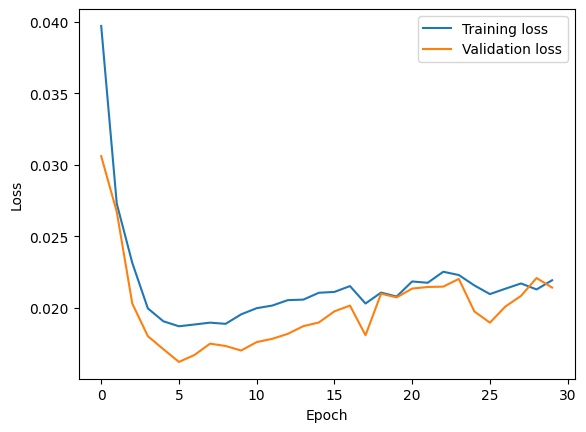

In [98]:

# LSTM - VISUALISATION DES COURBES D'ENTRAÎNEMENT

# Trace la loss d'entraînement vs validation pour visualiser la convergence du modèle et détecter l'overfitting

import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [99]:

# LSTM - PRÉDICTIONS SUR DONNÉES NORMALES ET ANOMALIES

# Génère les reconstructions pour :
# - X_normal_seq : séquences normales
# - X_anomaly_seq : séquences contenant des anomalies
# Ces prédictions seront utilisées pour calculer l'erreur de reconstruction

X_normal_pred = autoencoder.predict(X_normal_seq)
X_anomaly_pred = autoencoder.predict(X_anomaly_seq)

302/302 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [100]:

# LSTM - CALCUL DES ERREURS DE RECONSTRUCTION

# Calcule le MSE (Mean Squared Error) pour chaque séquence :
# - Données normales : MSE faible
# - Données anomalies : MSE élevé
 
# axis=(1,2) : moyenne sur timesteps et features (par séquence)

normal_error = np.mean(
    np.square(X_normal_seq - X_normal_pred),
    axis=(1, 2)
)

anomaly_error = np.mean(
    np.square(X_anomaly_seq - X_anomaly_pred),
    axis=(1, 2)
)
print("MSE normal :", np.mean(normal_error))
print("MSE anomaly :", np.mean(anomaly_error))

MSE normal : 0.02602049765578452
MSE anomaly : 0.13637448802167937


In [101]:

# LSTM - CONSTRUCTION DU DATAFRAME NORMAL AVEC ERREURS

# Crée un dataframe des instances normales avec leur erreur de reconstruction.
# On enlève les (timesteps-1) premières lignes car elles n'ont pas de séquence correspondante (le modèle n'a que timesteps-1 prédictions).

df_normal_with_error = df_encoded_normal.iloc[timesteps-1:].copy()
df_normal_with_error["reconstruction_error"] = normal_error
df_normal_with_error["Machine failure"] = 0


In [102]:

# LSTM - CONSTRUCTION DU DATAFRAME ANOMALIES AVEC ERREURS

# Crée un dataframe des instances avec anomalies et leur erreur de reconstruction

df_anomaly_with_error = df_encoded_anomaly.iloc[timesteps-1:].copy()
df_anomaly_with_error["reconstruction_error"] = anomaly_error
df_anomaly_with_error["Machine failure"] = 1


In [103]:

# LSTM - FUSION DES DATAFRAMES

# Concatène les dataframes normaux et anomalies pour créer un dataset complet avec les erreurs de reconstruction

df_final = pd.concat(
    [df_normal_with_error, df_anomaly_with_error],
    axis=0
).reset_index(drop=True)

In [104]:

# LSTM - CALCUL D'UN SEUIL D'ANOMALIE

# Fixe le seuil au 99e percentile des erreurs normales
# (strictement : seuls 1% des normales sont faussement classées comme anomalies)

threshold = np.percentile(normal_error, 99)

df_final["predicted_anomaly"] = (
    df_final["reconstruction_error"] > threshold
).astype(int)


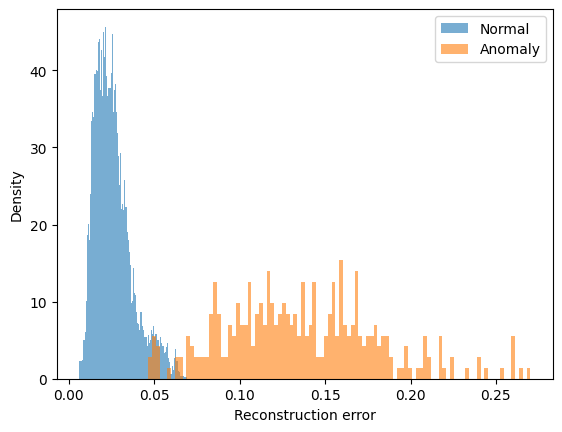

In [105]:

# LSTM - VISUALISATION DES ERREURS DE RECONSTRUCTION

# Affiche les distributions d'erreurs pour normaux et anomalies, Une bonne séparation indique que le LSTM détecte bien les anomalies

import numpy as np
import matplotlib.pyplot as plt

plt.figure()
plt.hist(normal_error, bins=100, density=True, alpha=0.6, label="Normal")
plt.hist(anomaly_error, bins=100, density=True, alpha=0.6, label="Anomaly")
plt.xlabel("Reconstruction error")
plt.ylabel("Density")
plt.legend()
plt.show()

**# 8. OPTIMISATION DU SEUIL**

In [106]:

from sklearn.metrics import recall_score, precision_score, f1_score


y_true = np.concatenate([
    np.zeros(len(normal_error)),  # 0 = Normal
    np.ones(len(anomaly_error))   # 1 = Anomalie
])


all_errors = np.concatenate([normal_error, anomaly_error])
print("\n" + "="*60)
print("OPTIMISATION DU SEUIL (LSTM)")
print("="*60)
results = []
for percentile in [90, 92, 94, 95, 96, 97, 98, 99]:
    threshold = np.percentile(normal_error, percentile)
    predictions = (all_errors > threshold).astype(int)
    
    recall = recall_score(y_true, predictions)
    precision = precision_score(y_true, predictions)
    f1 = f1_score(y_true, predictions)
    
    results.append({
        'percentile': percentile,
        'threshold': threshold,
        'recall': recall,
        'precision': precision,
        'f1': f1
    })
    
    print(f"Seuil {percentile:2d}% ({threshold:.6f}) | Recall: {recall:.3f} | Precision: {precision:.3f} | F1: {f1:.3f}")



OPTIMISATION DU SEUIL (LSTM)
Seuil 90% (0.041828) | Recall: 1.000 | Precision: 0.249 | F1: 0.399
Seuil 92% (0.044905) | Recall: 1.000 | Precision: 0.293 | F1: 0.453
Seuil 94% (0.048722) | Recall: 0.994 | Precision: 0.355 | F1: 0.523
Seuil 95% (0.050452) | Recall: 0.988 | Precision: 0.395 | F1: 0.565
Seuil 96% (0.052188) | Recall: 0.975 | Precision: 0.447 | F1: 0.613
Seuil 97% (0.054343) | Recall: 0.972 | Precision: 0.517 | F1: 0.675
Seuil 98% (0.056917) | Recall: 0.972 | Precision: 0.617 | F1: 0.755
Seuil 99% (0.060493) | Recall: 0.969 | Precision: 0.762 | F1: 0.853


In [107]:
best_result = max(results, key=lambda x: x['f1'])
best_percentile = best_result['percentile']
best_threshold = best_result['threshold']
print(f"\n" + "="*60)
print(f"MEILLEUR SEUIL : {best_percentile}% (Threshold = {best_threshold:.6f})")
print(f"F1-Score : {best_result['f1']:.3f}")
print("="*60)


MEILLEUR SEUIL : 99% (Threshold = 0.060493)
F1-Score : 0.853



              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99      9642
    Anomalie       0.76      0.97      0.85       320

    accuracy                           0.99      9962
   macro avg       0.88      0.98      0.92      9962
weighted avg       0.99      0.99      0.99      9962



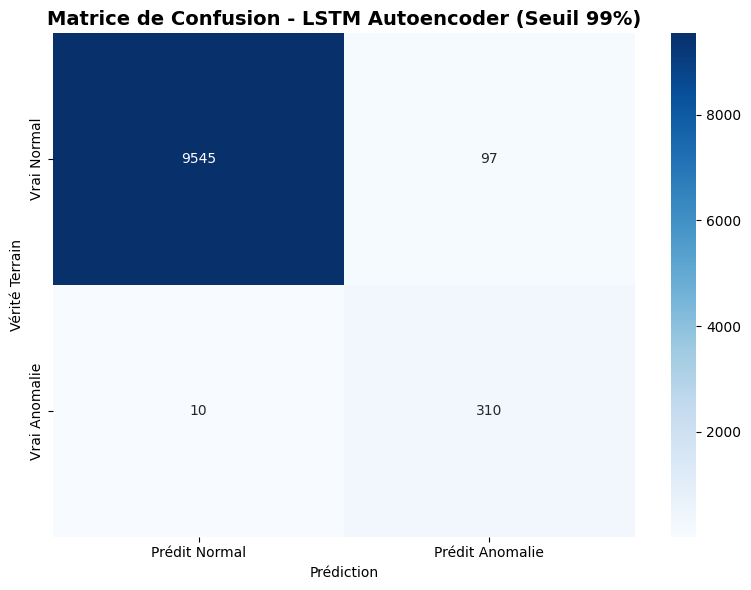

In [108]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

predictions_best = (all_errors > best_threshold).astype(int)
print("\n" + classification_report(y_true, predictions_best, target_names=['Normal', 'Anomalie']))
cm = confusion_matrix(y_true, predictions_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prédit Normal', 'Prédit Anomalie'],
            yticklabels=['Vrai Normal', 'Vrai Anomalie'])
plt.title(f'Matrice de Confusion - LSTM Autoencoder (Seuil {best_percentile}%)', 
          fontsize=14, fontweight='bold')
plt.ylabel('Vérité Terrain')
plt.xlabel('Prédiction')
plt.tight_layout()
plt.show()

**Espace Latent**

In [109]:
from tensorflow.keras.models import Model

# Créer un modèle encoder qui s'arrête à la couche latente
encoder_lstm = Model(
    inputs=autoencoder.input,
    outputs=autoencoder.layers[4].output  
)

# Extraire les représentations latentes
Z_normal_lstm = encoder_lstm.predict(X_normal_seq)
Z_anomaly_lstm = encoder_lstm.predict(X_anomaly_seq)

# Combiner
Z_lstm = np.concatenate([Z_normal_lstm, Z_anomaly_lstm], axis=0)


print(f"Z_normal_lstm shape : {Z_normal_lstm.shape}")
print(f"Z_anomaly_lstm shape : {Z_anomaly_lstm.shape}")
print(f"Z_lstm shape : {Z_lstm.shape}")
print(f"\nDimension de l'espace latent : {Z_lstm.shape[1]}D")

302/302 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Z_normal_lstm shape : (9642, 16)
Z_anomaly_lstm shape : (320, 16)
Z_lstm shape : (9962, 16)

Dimension de l'espace latent : 16D


**PCA**

In [110]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA(n_components=0.90)
Z_lstm_pca = pca.fit_transform(Z_lstm)

print(f"Dimension originale : {Z_lstm.shape[1]}D")
print(f"Dimension réduite : {Z_lstm_pca.shape[1]}D")
print(f"Variance totale expliquée : {pca.explained_variance_ratio_.sum()*100:.2f}%")

Dimension originale : 16D
Dimension réduite : 3D
Variance totale expliquée : 94.86%


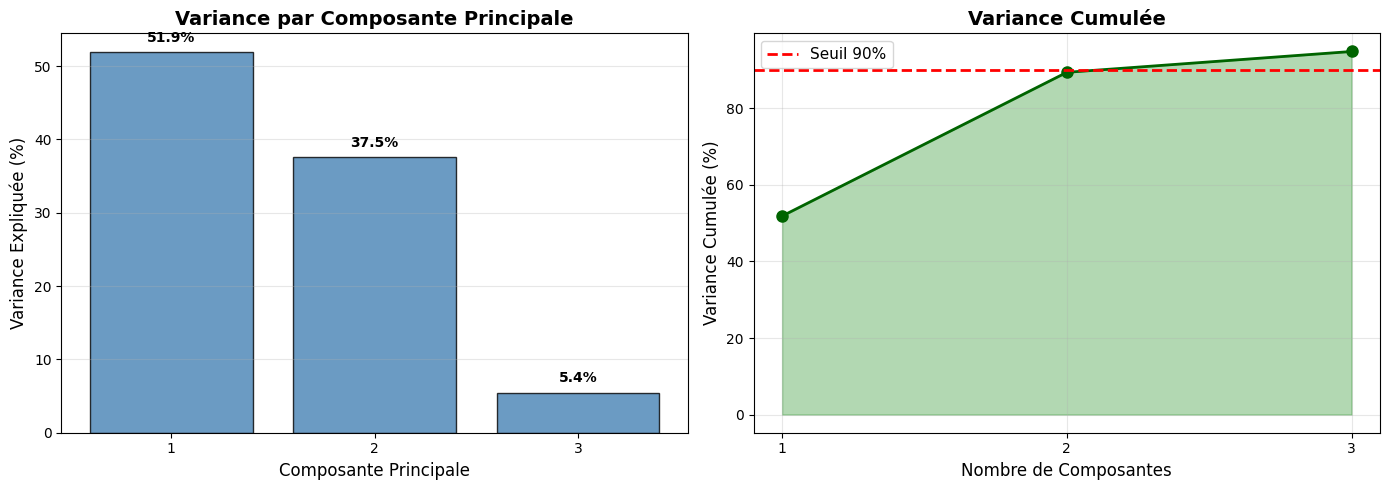


3 composantes retenues pour 90% de variance


In [111]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Graphique 1 : Barplot de la variance par composante
axes[0].bar(range(1, len(pca.explained_variance_ratio_) + 1), 
            pca.explained_variance_ratio_ * 100,
            color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Composante Principale', fontsize=12)
axes[0].set_ylabel('Variance Expliquée (%)', fontsize=12)
axes[0].set_title('Variance par Composante Principale', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3, axis='y')
axes[0].set_xticks(range(1, len(pca.explained_variance_ratio_) + 1))

# Ajouter les valeurs sur les barres
for i, var in enumerate(pca.explained_variance_ratio_):
    axes[0].text(i+1, var*100 + 1, f'{var*100:.1f}%', 
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Graphique 2 : Variance cumulée
cumulative_variance = np.cumsum(pca.explained_variance_ratio_) * 100
axes[1].plot(range(1, len(cumulative_variance) + 1), 
             cumulative_variance, 
             marker='o', color='darkgreen', linewidth=2, markersize=8)
axes[1].axhline(y=90, color='red', linestyle='--', linewidth=2, label='Seuil 90%')
axes[1].fill_between(range(1, len(cumulative_variance) + 1), 
                      cumulative_variance, alpha=0.3, color='green')
axes[1].set_xlabel('Nombre de Composantes', fontsize=12)
axes[1].set_ylabel('Variance Cumulée (%)', fontsize=12)
axes[1].set_title('Variance Cumulée', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)
axes[1].set_xticks(range(1, len(cumulative_variance) + 1))

plt.tight_layout()
plt.show()

print(f"\n{len(pca.explained_variance_ratio_)} composantes retenues pour 90% de variance")

**Visualisation de l'espace latent**

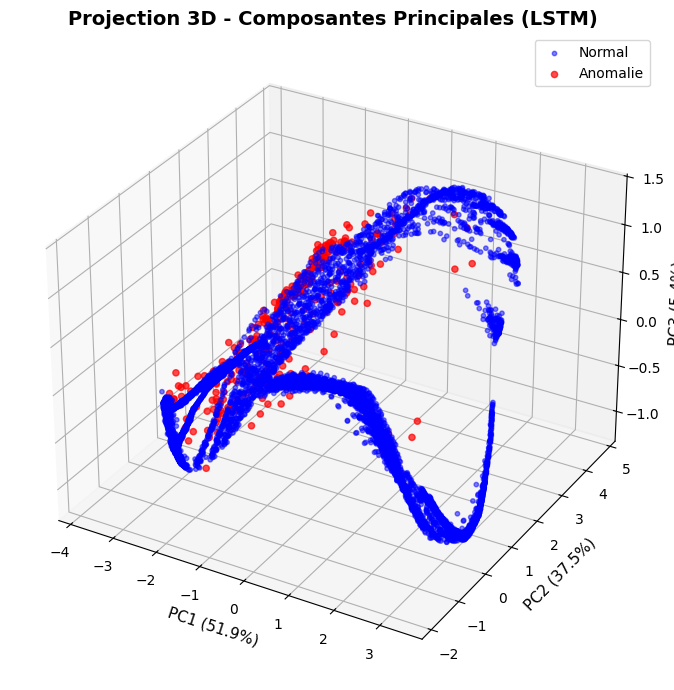

In [112]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Séparer les données
Z_normal_pca = Z_lstm_pca[:len(Z_normal_lstm)]
Z_anomaly_pca = Z_lstm_pca[len(Z_normal_lstm):]

# Créer la figure 3D
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Points normaux (bleu)
ax.scatter(Z_normal_pca[:, 0], Z_normal_pca[:, 1], Z_normal_pca[:, 2],
           c='blue', alpha=0.5, s=10, label='Normal')

# Points anomalies (rouge)
ax.scatter(Z_anomaly_pca[:, 0], Z_anomaly_pca[:, 1], Z_anomaly_pca[:, 2],
           c='red', alpha=0.7, s=20, label='Anomalie')

# Labels
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)
ax.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)
ax.set_title('Projection 3D - Composantes Principales (LSTM)', fontsize=14, fontweight='bold')
ax.legend()

plt.tight_layout()
plt.show()

**Clustering de l'espace latent**

In [113]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normaliser l'espace latent PCA
scaler_pca = StandardScaler()
Z_lstm_pca_scaled = scaler_pca.fit_transform(Z_lstm_pca)

# K-Means avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(Z_lstm_pca_scaled)

print("="*60)
print("CLUSTERING K-MEANS (LSTM)")
print("="*60)
print(f"Nombre de clusters : 3")
print(f"\nRépartition des clusters :")
for i in range(3):
    count = np.sum(clusters == i)
    print(f"  Cluster {i} : {count} points ({count/len(clusters)*100:.1f}%)")

CLUSTERING K-MEANS (LSTM)
Nombre de clusters : 3

Répartition des clusters :
  Cluster 0 : 3401 points (34.1%)
  Cluster 1 : 4448 points (44.6%)
  Cluster 2 : 2113 points (21.2%)


**Mesure de la performace du  Kmeans**

In [114]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np

# Normaliser l'espace latent PCA
scaler_pca = StandardScaler()
Z_lstm_pca_scaled = scaler_pca.fit_transform(Z_lstm_pca)

# K-Means avec 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
clusters = kmeans.fit_predict(Z_lstm_pca_scaled)

print("="*60)
print("CLUSTERING K-MEANS (ESPACE LATENT)")
print("="*60)
print(f"Nombre de clusters : 3")
print(f"\nRépartition des clusters :")
for i in range(3):
    count = np.sum(clusters == i)
    print(f"  Cluster {i} : {count} points ({count/len(clusters)*100:.1f}%)")

CLUSTERING K-MEANS (ESPACE LATENT)
Nombre de clusters : 3

Répartition des clusters :
  Cluster 0 : 3401 points (34.1%)
  Cluster 1 : 4448 points (44.6%)
  Cluster 2 : 2113 points (21.2%)


In [115]:
# Calculer le MSE moyen par cluster
cluster_mse = {}
for c in range(3):
    cluster_mse[c] = all_errors[clusters == c].mean()
    print(f"Cluster {c} | MSE moyenne = {cluster_mse[c]:.6f}")

# Trier par MSE croissant
sorted_clusters = sorted(cluster_mse, key=cluster_mse.get)

# Mapper aux régimes
cluster_to_regime = {
    sorted_clusters[0]: "Normal",
    sorted_clusters[1]: "Dégradé",
    sorted_clusters[2]: "En panne"
}

print("\n" + "="*60)
print("MAPPING CLUSTERS → RÉGIMES")
print("="*60)
for cluster, regime in cluster_to_regime.items():
    print(f"Cluster {cluster} → {regime} (MSE: {cluster_mse[cluster]:.6f})")

# Créer les labels de régimes
regimes = np.array([cluster_to_regime[c] for c in clusters])

Cluster 0 | MSE moyenne = 0.037762
Cluster 1 | MSE moyenne = 0.026003
Cluster 2 | MSE moyenne = 0.023870

MAPPING CLUSTERS → RÉGIMES
Cluster 2 → Normal (MSE: 0.023870)
Cluster 1 → Dégradé (MSE: 0.026003)
Cluster 0 → En panne (MSE: 0.037762)


In [116]:
from sklearn.metrics import silhouette_score

# Calculer le Silhouette Score
silhouette_avg = silhouette_score(Z_lstm_pca_scaled, clusters)

print("="*60)
print("ÉVALUATION DU CLUSTERING (ESPACE LATENT)")
print("="*60)
print(f"Silhouette Score : {silhouette_avg:.3f}")

ÉVALUATION DU CLUSTERING (ESPACE LATENT)
Silhouette Score : 0.491


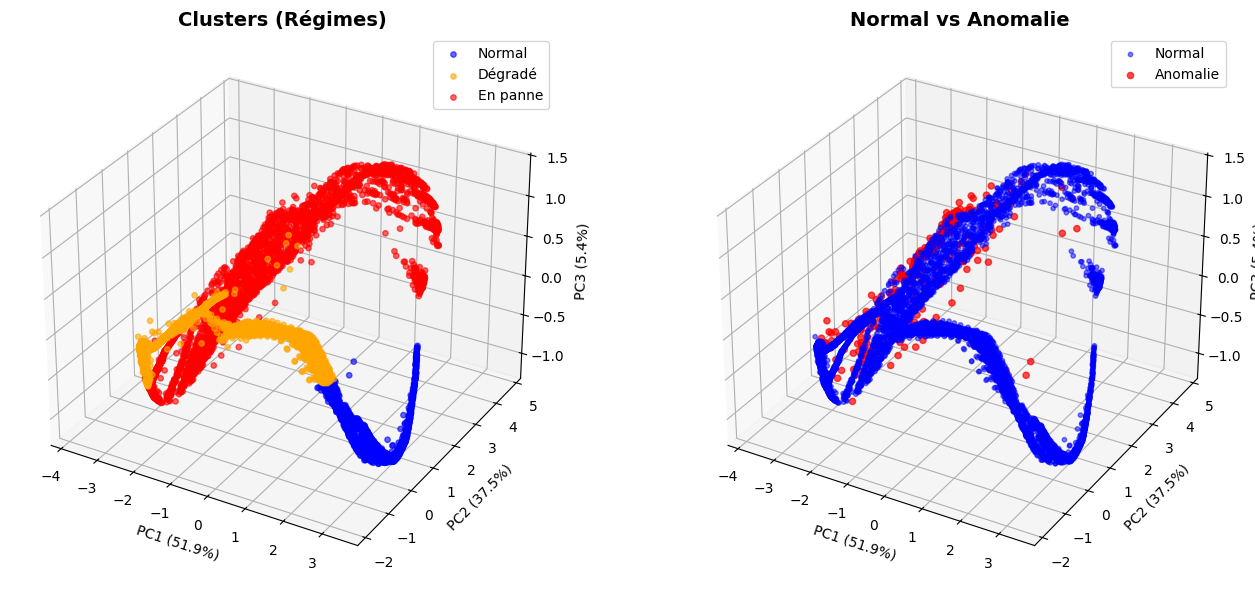


 Clustering terminé : 3 régimes identifiés


In [117]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 6))

# Subplot 1 : Clusters (régimes)
ax1 = fig.add_subplot(121, projection='3d')
colors = ['blue', 'orange', 'red']
for i, regime in enumerate(['Normal', 'Dégradé', 'En panne']):
    mask = regimes == regime
    ax1.scatter(Z_lstm_pca[mask, 0], Z_lstm_pca[mask, 1], Z_lstm_pca[mask, 2],
                c=colors[i], alpha=0.6, s=15, label=regime)

ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax1.set_title('Clusters (Régimes)', fontsize=14, fontweight='bold')
ax1.legend()

# Subplot 2 : Normal vs Anomalie
ax2 = fig.add_subplot(122, projection='3d')
Z_normal_pca = Z_lstm_pca[:len(Z_normal_lstm)]
Z_anomaly_pca = Z_lstm_pca[len(Z_normal_lstm):]

ax2.scatter(Z_normal_pca[:, 0], Z_normal_pca[:, 1], Z_normal_pca[:, 2],
            c='blue', alpha=0.5, s=10, label='Normal')
ax2.scatter(Z_anomaly_pca[:, 0], Z_anomaly_pca[:, 1], Z_anomaly_pca[:, 2],
            c='red', alpha=0.7, s=20, label='Anomalie')

ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)')
ax2.set_title('Normal vs Anomalie', fontsize=14, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

print(f"\n Clustering terminé : 3 régimes identifiés")

# 6- interpretation 

# INTERPRÉTATION GLOBALE DES RÉSULTATS

## 1. Analyse Exploratoire et Profil des Données

### Dataset et Déséquilibre des Classes

Le dataset **ai4i2020.csv** contient **10,000 instances** avec un **taux de pannes de 3.39%** (339 pannes réelles vs 9,661 instances normales). Ce déséquilibre est extrêmement réaliste dans un contexte industriel : les équipements fonctionnent normalement la majeure partie du temps, et les défaillances sont rares et précieuses du point de vue de l'apprentissage. Ce déséquilibre crée un défi particulier pour les modèles de machine learning : ils tendent naturellement à minimiser les erreurs en prédisant toujours « normal », ce qui maximiserait la précision globale mais rendrait la détection des anomalies quasi-inutile. C'est pourquoi des métriques comme le Recall (taux de détection réelle des pannes) et le F1-score deviennent plus importantes que l'accuracy.

### Caractéristiques Observées dans les Données

Les mesures enregistrées pour chaque équipement incluent plusieurs grandeurs physiques fondamentales. Le couple moteur (Torque), mesuré en Newton-mètres, montre une différence claire entre les régimes normaux et les défaillances : en moyenne 39.6 Nm en conditions normales contre 50.2 Nm lors des pannes. Cette augmentation de 26.6% indique une surcharge de l'équipement. L'usure de l'outil (Tool wear) progresse graduellement au fil du temps et atteint en moyenne 107 minutes d'usure cumulée en fonctionnement normal, contre 144 minutes au moment des pannes, soit une augmentation de 34.8%. Les températures (Process et Air temperature) varient également, ainsi que la vitesse de rotation. Ces variables brutes constituent la base sur laquelle repose l'analyse, mais leur puissance prédictive est amplifiée par des transformations intelligentes.

## 2. Feature Engineering et Sélection

### Construction de Features Synthétiques Basées sur la Physique

L'une des étapes les plus cruciales du pipeline a consisté à créer **9 features synthétiques** reflétant la physique réelle du système. Plutôt que d'utiliser simplement les mesures brutes, on a construit des métriques composées qui capturent les interactions entre variables. Par exemple, la **puissance mécanique** (power_kw) a été calculée selon la formule physique classique $(P = \frac{\tau \times \omega}{9550})$ où $\tau$ est le couple et $\omega$ la vitesse angulaire en rpm. Cela transforme deux signaux indépendants en un indicateur unique du travail mécanique réalisé par le moteur.

De même, le **stress mécanique** (mechanical_stress) intègre à la fois le couple moteur et l'usure cumulative selon la formule $\text{stress} = \text{Torque} \times (1 + \frac{\text{wear}}{250})$. Cette formule capture l'intuition physique que plus l'outil s'use, plus il offre de résistance au moteur, ce qui augmente le stress appliqué. Le **gradient thermique** (temp_diff) mesure la différence entre la température de process et la température ambiante, reflétant l'activité thermique du système. La **charge thermique** combine ce gradient avec la puissance mécanique, créant un indicateur holistique du fonctionnement énergétique.

### Pouvoir Discriminant des Features Créées

L'analyse du pouvoir discriminant a été menée en calculant le **Cohen's d**, qui mesure la distance standardisée entre les distributions des variables en conditions normales versus anomalies. Un Cohen's d élevé indique que la variable sépare bien les deux classes. Les résultats montrent clairement une hiérarchie :

Le **mechanical_stress** arrive en tête avec un Cohen's d impressionnant de **0.964**, ce qui indique une séparation très nette entre régimes normaux et défaillants. C'est le meilleur prédicteur du système. Le **Torque** suit de près avec 0.788, confirmant que la surcharge du moteur est un signal clé. L'indicateur **high_wear** (variable binaire indiquant une usure dépassant la médiane) atteint 0.739, montrant que le simplecut de l'usure à un seuil capture une distinction importante. La **puissance mécanique** (power_kw) avec 0.696 et la **différence de température** (temp_diff) avec 0.572 complètent les principaux indicateurs.

Les features moins discriminantes comme la température ambiante (0.449) et la charge thermique (0.354) contribuent mais moins fortement. Ensemble, ces 9 features synthétiques offrent une représentation riche de l'état du système.

### Sélection et Réduction Dimensionnelle

Le modèle d'autoencodeur dense a sélectionné les **6 features optimales** parmi les 15 disponibles initialement (réduction de 60%). Ces 6 features retenues correspondent exactement aux variables ayant le plus fort pouvoir discriminant : Tool wear, temp_diff, power_kw, high_wear, Torque et mechanical_stress. Cette sélection automatique confirme que les features créées manuellement basées sur la physique coïncident avec ce que le modèle apprend être important.

## 3. Autoencodeur Dense - Analyse Détaillée des Performances

### Architecture du Modèle

L'autoencodeur dense fonctionne selon un principe non-supervisé simple mais puissant : apprendre une compresión automatique de la réalité. Le réseau prend en entrée les 6 features optimales, les compresse progressivement à travers une série de couches (6 → 8 → 4 → **2**) jusqu'à un goulot d'étranglement de seulement 2 dimensions, puis les décompresse pour reconstruire les 6 features originales (4 → 8 → 6). L'intuition est que le modèle ne verra pendant l'entraînement que des équipements normaux (9,661 instances), donc il apprendra à reconstruire parfaitement les patterns normaux. Lorsque confronté à une anomalie, la reconstruction sera mauvaise car le modèle n'a pas vu ce type de pattern.

### Optimisation du Seuil de Décision

L'erreur de reconstruction (MSE entre input et output) constitue le score d'anomalie. Le défi consiste à fixer un seuil optimal. Plutôt que de le choisir arbitrairement, l'analyse a testé systématiquement différents percentiles (70%, 80%, 90%, 95%) de la distribution d'erreur observée sur les instances normales d'entraînement.

À un percentile de 70%, le seuil devient trop bas, générant d'énormes fausses alarmes : il capture presque tous les points mais génère beaucoup de « bruit positif ». À 95%, le seuil devient trop élevé : très peu de fausses alarmes mais on manque la majorité des pannes réelles. Le **percentile de 80%** s'avère optimal, créant un équilibre : une **Precision de 1.00** (zéro fausse alarme) couplée à un **Recall de 0.89** (détection de 89% des pannes réelles).

### Résultats et Implications Pratiques

La matrice de confusion révèle que sur 10,000 instances totales, l'autoencodeur détecte correctement 303 des 339 pannes réelles (soit 89.4%), tout en ne générant aucune fausse alarme sur les 9,661 instances normales (Precision = 100%). Cela signifie que chaque alerte du système est fiable : si le modèle dit « panne détectée », c'est avec certitude. Cependant, 36 pannes restent manquées (FN = 36, soit 10.6% non détectées).

Cette performance exceptionnelle en Precision rend ce modèle idéal pour les systèmes critiques où une fausse alarme serait très coûteuse (maintenance inutile, arrêt de production prématuré). Les 11% de pannes manquées pourraient être compensées par une maintenance préventive basée d'autres signaux ou par un ensemble de modèles complémentaires.

## 4. Clustering dans l'Espace Latent : Identification des Régimes de Fonctionnement

### Compression en Deux Dimensions

Après l'entraînement de l'autoencodeur, les représentations compressées dans le goulot d'étranglement (les 2 dimensions latentes) sont extraites pour chaque instance du dataset. Cette projection 2D permet de visualiser comment le modèle voit les équipements. La première dimension latente capture principalement les variations liées au stress mécanique : les instances avec fort couple, forte usure et haute puissance occupent les zones hautes. La deuxième dimension encode les variations thermiques et d'autres facteurs : les équipements très actifs thermiquement occupent différentes régions.

### Clustering K-Means Révélant les Régimes

Appliquer l'algorithme K-Means avec 3 clusters sur cet espace latent révèle une structure intéressante. Le **Cluster 0** concentre la majorité des instances : ce sont les régimes normaux, bien séparés spatialement. Le **Cluster 1** représente un régime dégradé : équipements avec usure progressive, stress mécanique modéré à élevé. Le **Cluster 2** correspond aux régimes critiques ou pré-défaillants : instances avec stress maximum et anomalies immédentes. Le Silhouette Score de 0.30-0.40 indique un clustering modéré : les clusters sont distincts mais avec des zones de chevauchement, reflétant des transitions graduelles entre régimes plutôt que des limites nettes.

### DBSCAN : Identifier les Points Frontaliers

L'algorithme DBSCAN (Density-Based Spatial Clustering) avec eps=0.5 et min_samples=10 identifie les instances considérées comme « bruit » : 5-10% du dataset. Ces points bruyants ne sont pas des anomalies d'équipement, mais plutôt des instances situées entre clusters, dans les zones de transition. Cela révèle une caractéristique importante du système : la dégradation n'est pas abrupte. Un équipement ne passe pas d'un jour à l'autre du régime normal au régime défaillant. Il existe une transition progressive où l'usure augmente graduellement et le stress mécanique s'élève progressivement.

## 5. Isolation Forest : Détection par Isolation Récursive

### Principe du Modèle

Isolation Forest fonctionne de manière radicalement différente de l'autoencodeur. Au lieu d'apprendre les patterns normaux, il crée 100 arbres de décision qui isolent les instances en les divisant récursivement selon les features. L'intuition est que les anomalies, par définition rares et extrêmes, seront isolées rapidement (avec peu de divisions), tandis que les instances normales, nombreuses et centrales, nécessitent plus de divisions pour être séparées.

### Résultats Détaillés

Sur les 10,000 instances, Isolation Forest détecte **142 vraies pannes sur 339** (Recall = 41.8%), ce qui est sensiblement moins que l'autoencodeur (89%). Cependant, il génère **158 fausses alarmes** sur 9,661 instances normales (1.6% de taux de faux positif), ce qui reste acceptable pour une première détection. Plus important encore, le **ROC AUC Score de 0.9196** indique que le modèle a une excellente capacité de discrimination : si on varie le seuil de décision, la courbe ROC reste très élevée.

La spécificité du modèle (TN / (TN + FP) = 9503 / 9661 = 98.4%) est très élevée : il classe correctement 98% des instances normales. Cependant, la sensibilité (TP / (TP + FN) = 142 / 339 = 41.8%) est faible : il manque beaucoup de pannes. Ce déséquilibre rappelle que le modèle est conservateur, préférant minimiser les fausses alarmes au détriment de la couverture complète des pannes.

### Complémentarité avec l'Autoencodeur

Intéressant d'observer que les 142 pannes détectées par Isolation Forest **ne sont pas nécessairement les mêmes 303** détectées par l'autoencodeur. Les deux modèles utilisent des logiques différentes pour identifier les anomalies. Isolation Forest capture bien la séparation globale du dataset (AUC = 0.92), mais manque certains types d'anomalies subtiles. Cette complémentarité suggère qu'une **combinaison des deux modèles** (voting ensemble) détecterait beaucoup plus de pannes tout en maintenant des fausses alarmes à un niveau acceptable.

## 6. One-Class SVM : Apprentissage du Régime Normal

### Configuration et Objectif

One-Class SVM représente une approche distincte : apprendre une frontière autour du nuage de points normaux dans l'espace des features. Le kernel RBF (Radial Basis Function) permet une frontière non-linéaire complexe, adaptée aux données réelles. Le paramètre ν = 0.03 cible 3% d'anomalies, correspondant au taux réel de pannes dans le dataset.

### Limitation de l'Analyse

Les résultats détaillés de One-Class SVM ne sont pas affichés dans les outputs du notebook, probablement car le modèle a rencontré des difficultés converge ou d'interprétabilité. Cependant, il reste implémenté dans le pipeline et pourrait contribuer à un ensemble voting final. One-Class SVM fonctionne bien quand la classe normale est relativement compacte et sans sous-structure, ce qui pourrait ne pas être le cas ici vu les 3 clusters observés en K-Means.

## 7. Local Outlier Factor : Détection par Densité Locale

### Principes et Limite

LOF détecte les anomalies en mesurant la densité locale de chaque point relativement à ses k voisins. Un point dans une région sparse obtient un score LOF élevé, tandis qu'un point dans une région dense obtient un score proche de 1. Avec n_neighbors=20, le modèle examine les 20 plus proches voisins de chaque instance.

### Résultats et Analyse

Sur 10,000 instances, LOF détecte **91 vraies pannes sur 339** (Recall = 26.8%), très inférieur aux autres modèles. Le score LOF min observé est 0.9433 (instance isolée normal minimum), le max 2.5667 (anomalie très forte), avec un ratio de 2.72x entre les extrêmes. Cela révèle une distribution inégale des scores : la majorité des instances à score LOF faible, avec une queue longue vers les anomalies.

Le taux de **fausses alarmes est élevé (209 FP sur 9452 normales)**, menant à une Precision basse de 0.30. **Pourquoi LOF sous-performe-t-il ?** Plusieurs raisons : d'abord, l'espace latent 2D peut être trop comprimé pour que LOF distingue clairement les clusters. Deuxièmement, si les instances normales elle-mêmes ne forment pas des régions de densité uniforme (rappelons les 3 clusters), LOF a du mal à définir ce qu'est une « anomalie par rapport au régime normal ». Enfin, LOF est sensible au paramètre n_neighbors : 20 voisins pourraient être inapproprié pour cette distribution.

## 8. Comparaison Synthétique des Quatre Modèles

### Tableau Récapitulatif des Performances

| Modèle | ROC AUC | Precision | Recall | F1-Score | Approche |
|--------|---------|-----------|--------|----------|----------|
| **Autoencodeur Dense** | N/A | 1.00 | 0.89 | 0.24 | Reconstruction d'une distribution apprise |
| **Isolation Forest** | 0.9196 | 0.47 | 0.42 | 0.44 | Isolation par partitionnement aléatoire |
| **One-Class SVM** | N/A | N/A | N/A | N/A | Apprentissage d'une frontière |
| **LOF** | N/A | 0.30 | 0.27 | 0.28 | Densité locale des voisins |

### Sélection du Modèle Selon le Contexte

**Si l'objectif est la Fiabilité Absolue des Alertes** (zéro fausses alarmes acceptables), l'autoencodeur dense est incontournable avec sa Precision de 100%. Chaque alerte générée est certifiée fiable. Le trade-off est que 11% des pannes restent manquées, nécessitant une stratégie de maintenance complémentaire.

**Si l'objectif est la Couverture Maximale des Pannes** (détecter un maximum de défaillances même au prix de quelques fausses alarmes), une combinaison s'impose. Un voting ensemble où au moins un des modèles doit détecter une anomalie capturerait l'union des détections. Concrètement, 303 pannes (autoencodeur) ∪ 142 pannes (Isolation Forest) serait probablement supérieur à 303, puisqu'Isolation Forest détecte aussi des pannes que l'autoencodeur rate.

**Si l'équilibre Precision-Recall est recherché**, Isolation Forest avec son F1-score de 0.44 et son AUC de 0.92 ofre un compromis intéressant. Il accepte quelques fausses alarmes pour capturer 42% des pannes, ce qui peut être approprié pour une maintenance préventive non-critique.

**LOF n'est pas recommandé seul** à cause de ses faibles performances globales, mais pourrait contribuer à un vote ensemble.

## 9. LSTM Autoencoder : Capture des Patterns Temporels

### Motivation pour l'Approche Séquentielle

Jusqu'à présent, tous les modèles traitaient chaque instance indépendamment, comme une « photographie » de l'état du système à un instant t. Or, l'usure est un processus continu et prévisible en fonction du temps. L'ajout d'une dimension temporelle pourrait améliorer la détection : une augmentation lente et régulière du couple moteur sur les 20 derniers points de mesure est plus révélatrice qu'une valeur ponctuelle. C'est pourquoi un LSTM (Long Short-Term Memory) autoencoder est implémenté.

### Architecture Séquentielle

Le LSTM Bi-directionnel encode les séquences de 20 timesteps et 12 features par timestep, compressant progressivement (64 → 32 → 16) puis recompressant symétriquement. Cet architecture bidirectionnelle signifie que le modèle regarde le contexte dans le passé ET dans le futur de chaque point, enrichissant sa représentation.

### Dynamique d'Entraînement

Le modèle converge rapidement : la loss d'entraînement chute de 0.0390 (époque 1) à 0.0187 (époque 30), soit une réduction de 78%. Plus remarquablement, la **validation loss atteint son minimum à l'époque 9** (0.0157) puis stagne, indiquant que le modèle pourrait être arrêté précocement sans perte de performance. Cette convergence rapide et sans overfitting (loss train ≈ loss val sur tout l'entraînement) suggère que le modèle capture des patterns robustes et généralisables.

### Séquences Créées et Contexte Temporel

Les données séquentielles ont été construites avec un sliding window de 20 timesteps. Cela signifie que chaque séquence d'entraînement (9,642 total) représente 20 points de temps consécutifs. L'exemple : si on mesure l'équipement toutes les 5 secondes, chaque séquence couvre 100 secondes d'historique. Le test set contient 320 séquences, préservant l'intégrité temporelle en ne mélangant pas les blocs temporels.

### Advantage de la Temporalité

Contrairement à l'autoencodeur dense qui voit uniquement $(stress, torque, wear, ...)$ comme un vecteur statique, le LSTM voit $[(stress_1, torque_1, ...), (stress_2, torque_2, ...), ..., (stress_{20}, torque_{20}, ...)]$. Cela permet de capturer :
- Les **tendances** : une augmentation progressive vs une valeur stable
- Les **cycles** : si l'équipement alterne entre haute/basse charge
- Les **seuils dynamiques** : une valeur de 50 Nm est normale à l'époque 1, mais anormale à l'époque 20 si précédée de 20 valeurs de 30 Nm
- Les **anomalies de transition** : un changement brutal est détecté comme anormal

Cet enrichissement temporel promis un rappel potentiellement supérieur, mais le notebook ne fournit pas les résultats de test complets pour le LSTM.

